In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions
from Bio.PDB.Polypeptide import one_to_three
from Bio.PDB.Polypeptide import three_to_one
from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
# from small_script.myFunctions import *
sys.path.insert(0, "/Users/weilu/openmmawsem")
from helperFunctions.myFunctions import *
from collections import defaultdict
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})

In [3]:
# pre = "/Users/weilu/Research/server_backup/feb_2019/jan_optimization/gammas/"
# pre = "/Users/weilu/Research/server/april_2019/optimization_test/gammas/"
pre = "/Users/weilu/Research/server/sep_2019/peptide_optimization_trial_6/optimization/gammas/"
trial_name = "trial_6"
cutoff = 500


In [4]:

# pp = "cath-dataset-nonredundant-S20Clean_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0"
# pp = "proteins_name_list_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0phi_burial_well4.0"
pp = f"protein_list_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0phi_burial_well4.0"

A_name = pp + "_A"
B_name = pp + "_B"
B_filtered_name = pp + "_B_filtered"
P_name = pp + "_P"
Gamma_name = pp + "_gamma"
Gamma_filtered_name = pp + "_gamma_filtered"
Lamb_name = pp + "_lamb"
Lamb_filtered_name = pp + "_lamb_filtered"

A = np.loadtxt(pre+A_name)
B = np.loadtxt(pre+B_name)
B_filtered = np.loadtxt(pre+B_filtered_name, dtype=complex, converters={
                           0: lambda s: complex(s.decode().replace('+-', '-'))})
Gamma = np.loadtxt(pre+Gamma_name)
Gamma_filtered = np.loadtxt(pre+Gamma_filtered_name, dtype=complex, converters={
                           0: lambda s: complex(s.decode().replace('+-', '-'))})
Lamb = np.loadtxt(pre+Lamb_name, dtype=complex, converters={
                           0: lambda s: complex(s.decode().replace('+-', '-'))})
Lamb_filtered = np.loadtxt(pre+Lamb_filtered_name, dtype=complex, converters={
                           0: lambda s: complex(s.decode().replace('+-', '-'))})

half_B_name = pp + "_half_B"
half_B = np.loadtxt(pre+half_B_name)
other_half_B_name = pp + "_other_half_B"
other_half_B = np.loadtxt(pre+other_half_B_name)
std_half_B_name = pp + "_std_half_B"
std_half_B = np.loadtxt(pre+std_half_B_name)


# pre = "/Users/weilu/Research/server/april_2019/"
location = pre + "../../phis/protein_list_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0phi_burial_well4.0_phi_decoy_summary.txt"
A_prime = np.loadtxt(location)





/Users/weilu/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


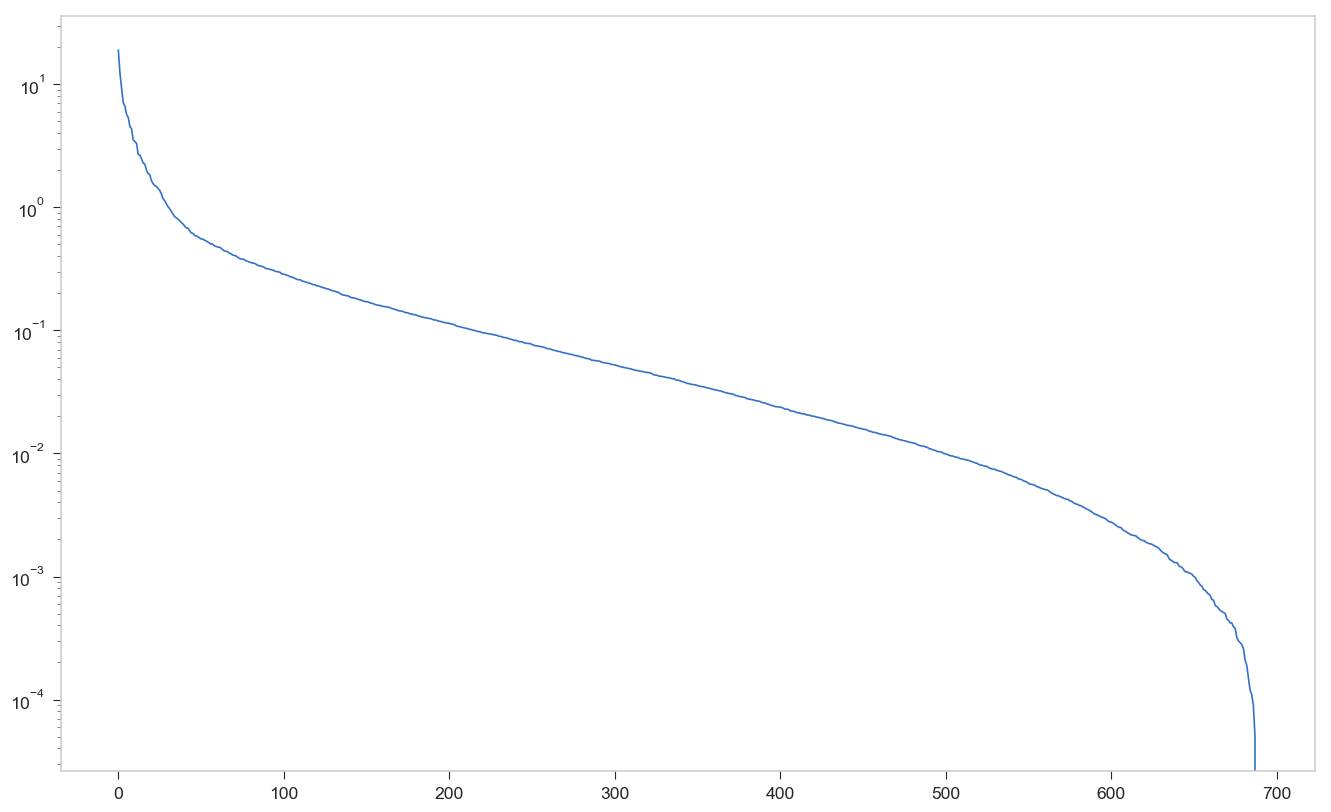

In [5]:
plt.plot(Lamb)
plt.yscale("log")

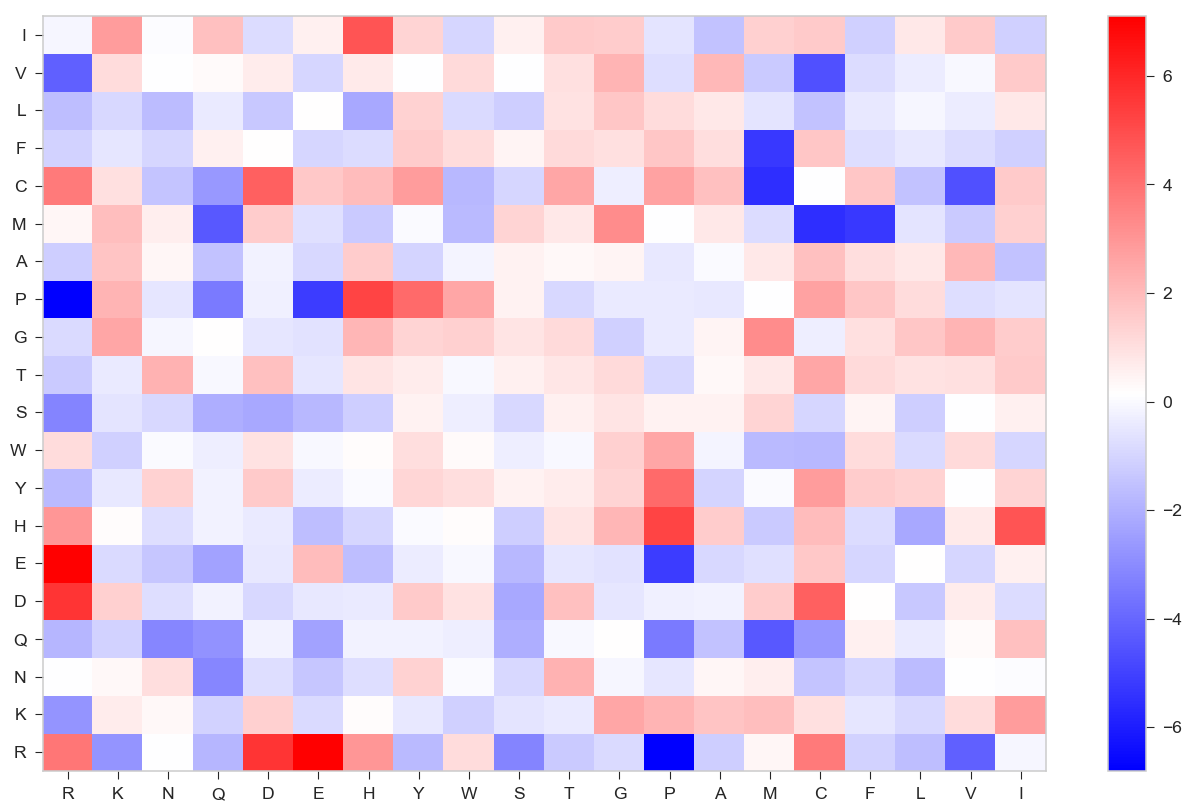

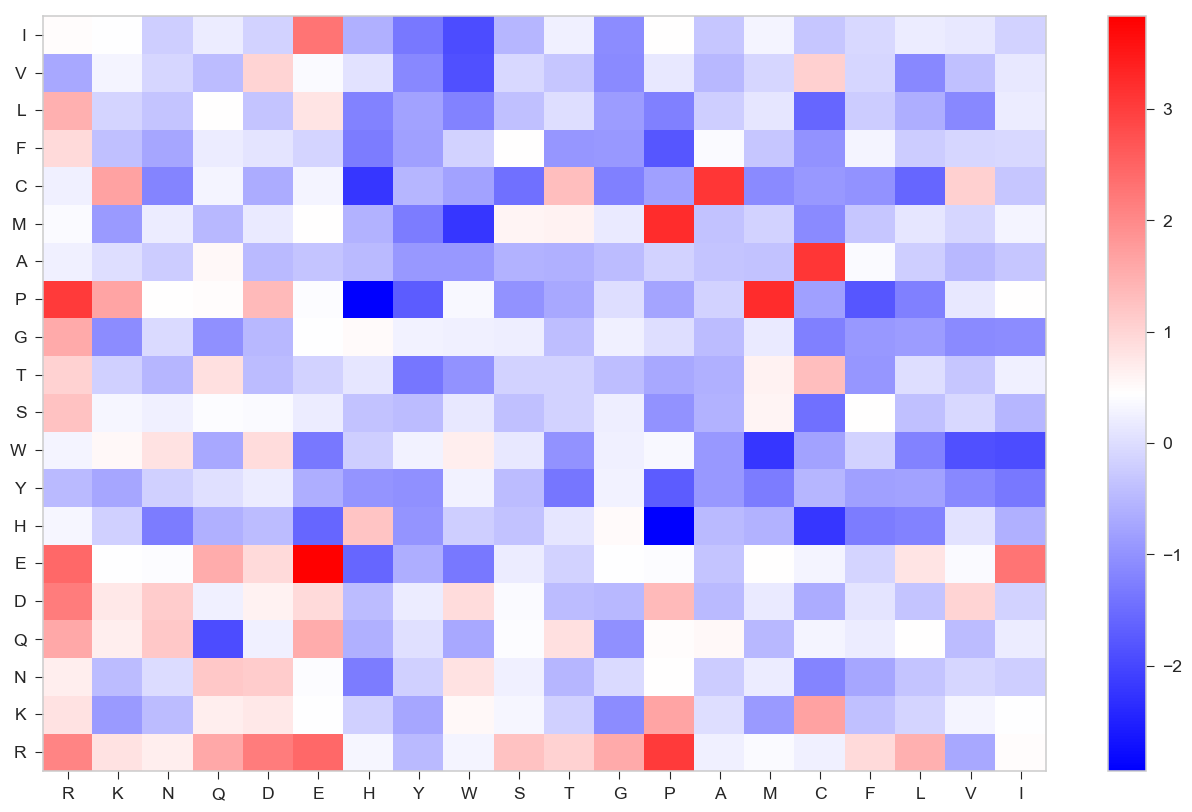

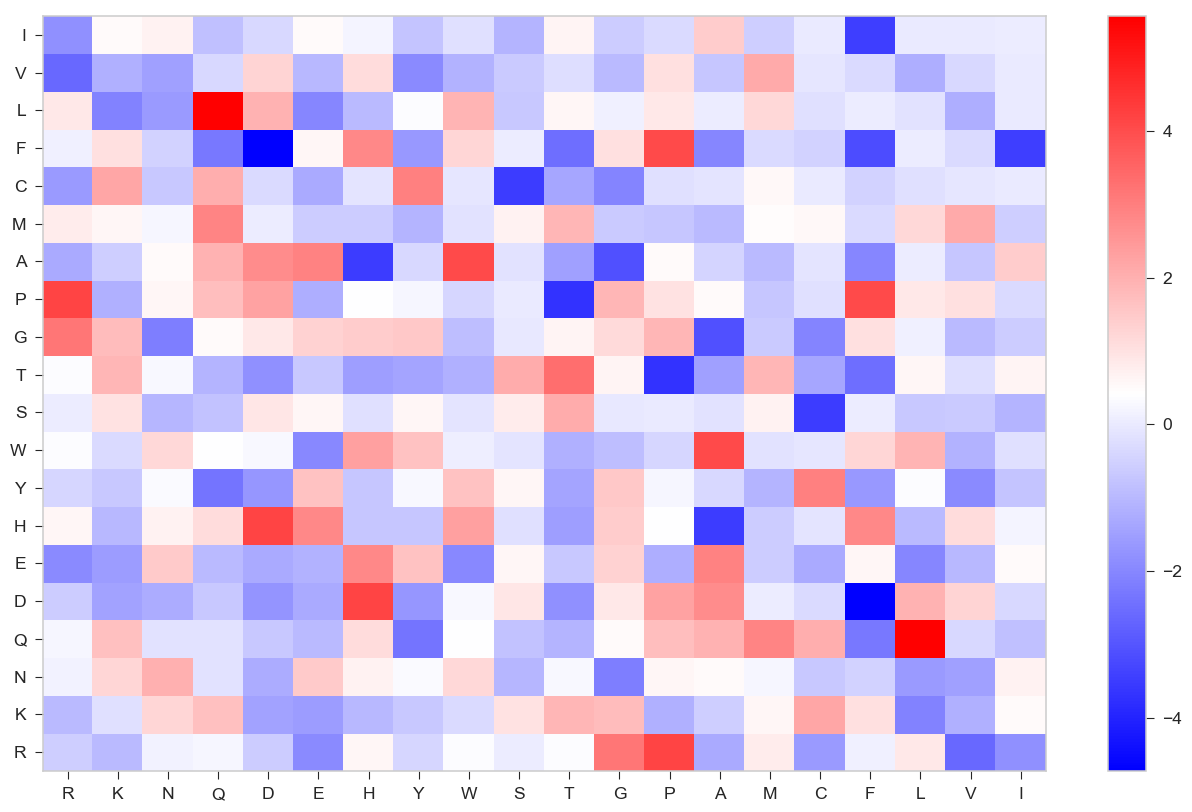

In [6]:
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb, 
                                                                   cutoff_mode, P)
filtered_gamma = np.dot(filtered_B_inv, A)
filtered_B = np.linalg.inv(filtered_B_inv)
plot_contact_well(filtered_gamma[:210], inferBound=True)
plot_contact_well(filtered_gamma[210:420], inferBound=True)
plot_contact_well(filtered_gamma[420:], inferBound=True)

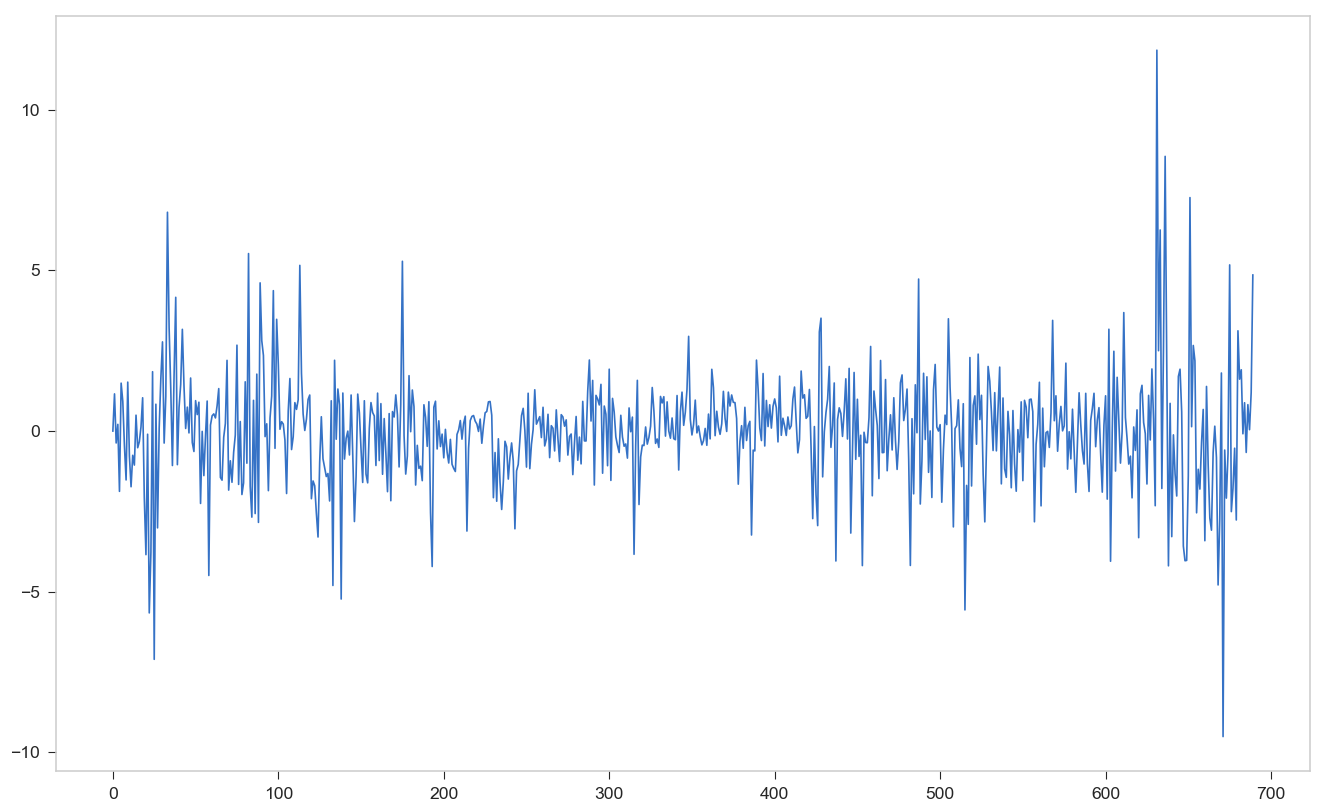

In [7]:
plt.plot(filtered_gamma)

In [8]:
# maximum difference between loaded and computed is 1e-5.
max(lamb-Lamb)

(1.8839964817586596e-05+0j)

In [9]:
save_gamma_pre = "/Users/weilu/Research/server/sep_2019/saved_gammas/"
np.savetxt(f"{save_gamma_pre}/{trial_name}_cutoff{cutoff}", filtered_gamma)

In [10]:
# os.chdir('/Users/weilu/opt/notebook/Optimization')

In [11]:
gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/original_gamma"
original_gamma = np.loadtxt(gamma_file_name)

In [12]:
np.dot(A_prime, original_gamma)

-552.0947006999806

In [13]:
# we want to impose additional contraint so that A' * gamma = constnat.(-562.23)
c = np.dot(A_prime, original_gamma)
B_inv = filtered_B_inv
lambda_2 = (A_prime.dot(B_inv).dot(A) - c) / (A_prime.dot(B_inv).dot(A_prime) )
gamma_new = B_inv.dot(A-A_prime*lambda_2)

In [18]:
np.dot(A_prime, gamma_new)

-552.0947006999791

In [15]:
# impose A'gamma
save_gamma_pre = "/Users/weilu/Research/server/sep_2019/saved_gammas/"
np.savetxt(f"{save_gamma_pre}/{trial_name}_cutoff{cutoff}_impose_Aprime_constraint", gamma_new)

In [16]:
def output_E_decoy(hamiltonian, training_set_file, gamma_file_name, training_decoy_method, num_decoys, test_set_file=None, test_decoy_method=None, use_filtered_gammas=False, **kwargs):
    if test_set_file is None:
        test_set_file = training_set_file
    if test_decoy_method is None:
        test_decoy_method = training_decoy_method
    test_set = read_column_from_file(test_set_file, 1)
    z_scores = []
    e_natives = []
    e_mgs = []
    e_mg_stds = []
    e_decoys = []
    names = []
    for i, protein in enumerate(test_set):
#         print(i, protein)
        # print(protein, hamiltonian, training_set_file, gamma_file_name, test_decoy_method, num_decoys, use_filtered_gammas)
        e_native, e_decoy = evaluate_hamiltonian_wei(
            protein, hamiltonian, training_set_file, gamma_file_name, test_decoy_method, num_decoys, use_filtered_gammas, outputDecoy=True, **kwargs)
        # print(protein, z)
        e_natives.append(e_native)
        e_decoys.append(e_decoy)
        names.append(protein)
    return names, e_natives, e_decoys

do = os.system

In [25]:
# pre = "/Users/weilu/Research/server/sep_2019/peptide_optimization_trial_5/optimization/gammas/"
os.chdir(f"{pre}/..")
# gamma_file_name = "gamma_iter1_combined_mar06.dat"
# gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/cutoff100"
gamma_file_name = f"{save_gamma_pre}/{trial_name}_cutoff{cutoff}_impose_Aprime_constraint"

names, e_natives, e_decoys = output_E_decoy("phi_list.txt", "protein_list", gamma_file_name, "shuffle", 1000, mode=0)



In [30]:
figure_folder = "/Users/weilu/Dropbox/Optimization_Xfunnel/Sep28_figures"
do(f"mkdir -p {figure_folder}")
for name, e_native, e_decoy in zip(names, e_natives, e_decoys):
    # print(name)
    plt.figure()
    _ = plt.hist(e_decoy, bins=50)
    plt.vlines(e_native, ymin=0, ymax=100, color="red")
    _ = plt.title(name)
    plt.savefig(f"{figure_folder}/{name}.png")
    plt.close()

In [20]:
os.chdir(f"{pre}/..")
# gamma_file_name = "gamma_iter1_combined_mar06.dat"
# gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/cutoff100"
gamma_file_name = f"{save_gamma_pre}/{trial_name}_cutoff{cutoff}_impose_Aprime_constraint"

data = validate_hamiltonian_wei("phi_list.txt", "protein_list", gamma_file_name, "shuffle", 100, mode=0)
data


0 3.386869557854129


,Protein,Z_scores,E_native,E_mgs,Std_mg
0,5NMG_0,3.386870,-511.160837,-494.765797,4.840765
1,5NMG_1,2.866160,-511.160837,-494.751246,5.725288
2,5NMG_2,2.756145,-511.160837,-494.156164,6.169730
3,5NMG_3,2.719634,-511.160837,-494.746348,6.035552
4,5NMG_4,3.512124,-511.160837,-494.027657,4.878296
5,5NMG_5,3.039465,-511.160837,-494.452429,5.497154
6,5NMG_6,3.001962,-511.160837,-495.431597,5.239654
7,5NMG_7,2.414770,-511.160837,-495.887233,6.325076
8,5NMG_8,3.179537,-511.160837,-494.909619,5.111189
9,5NMG_9,2.980284,-511.160837,-494.388086,5.627904


In [24]:
import pyemma

PCA(dim=-1, mean=array([-1. , -1.5, -2.5,  1. ,  1.5,  2.5]), skip=0,
  stride=1, var_cutoff=0.95)

In [28]:
data = X.T # X.shape

In [30]:
data.shape

(2, 6)

In [89]:
data = X
pca = pyemma.coordinates.pca(data)

In [100]:
pca.get_output()

[array([[-1.],
        [ 1.]], dtype=float32)]

In [98]:
pyemma.coordinates.transform.pca.pca()

AttributeError: module 'pyemma.coordinates.transform.pca' has no attribute 'pca'

In [73]:
pca.fit(data)

PCA(dim=-1, mean=array([-1. , -1.5, -2.5,  1. ,  1.5,  2.5]), skip=0,
  stride=1, var_cutoff=0.95)

In [72]:
pca.fit_transform(data)

array([[-1.],
       [ 1.]])

In [90]:
pc1 = pca.eigenvectors[0]

In [47]:
data

array([[-1, -2, -3,  1,  2,  3],
       [-1, -1, -2,  1,  1,  2]])

In [50]:
t_bar = np.mean(data, axis=0)

In [77]:
t_bar

array([-1. , -1.5, -2.5,  1. ,  1.5,  2.5])

In [85]:
s = np.dot((data - t_bar).T, data - t_bar)

In [92]:
np.dot(s, pc1)

array([0., 0., 0., 0., 0., 0.])

In [93]:
eigen1

2.0

In [94]:
pca.eigenvalues

array([ 2.00000000e+00,  2.12443557e-32,  1.21898706e-48,  0.00000000e+00,
       -1.07403546e-16, -4.62394046e-16])

In [96]:
pca.eigenvectors.round(3)

array([[ 0.   , -0.   ,  0.   ,  1.   ,  0.   , -0.   ],
       [ 0.5  , -0.   ,  0.   ,  0.   ,  0.197, -0.843],
       [ 0.5  , -0.   ,  0.   ,  0.   ,  0.73 ,  0.467],
       [ 0.   , -1.   ,  0.   ,  0.   , -0.   , -0.   ],
       [-0.5  , -0.   ,  0.707,  0.   ,  0.463, -0.188],
       [-0.5  , -0.   , -0.707,  0.   ,  0.463, -0.188]])

In [91]:
eigen1 = pca.eigenvalues[0]

In [82]:
s = (np.outer((data[0] - t_bar),(data[0] - t_bar).T) + np.outer((data[1] - t_bar),(data[1] - t_bar)))/2

In [83]:
s

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.25,  0.25,  0.  , -0.25, -0.25],
       [ 0.  ,  0.25,  0.25,  0.  , -0.25, -0.25],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.25, -0.25,  0.  ,  0.25,  0.25],
       [ 0.  , -0.25, -0.25,  0.  ,  0.25,  0.25]])

In [84]:
np.dot(s, pc1)

array([0., 0., 0., 0., 0., 0.])

In [64]:
pca.eigenvalues

array([ 2.00000000e+00,  2.12443557e-32,  1.21898706e-48,  0.00000000e+00,
       -1.07403546e-16, -4.62394046e-16])

In [51]:
t_bar

array([-1. , -1.5, -2.5,  1. ,  1.5,  2.5])

In [101]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]]).T
# X = X
pca = PCA(n_components=2)
pca.fit(X)  


print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

[1. 0.]
[1.41421356 0.        ]


In [102]:
pca.components_

array([[ 0.  ,  0.5 ,  0.5 ,  0.  , -0.5 , -0.5 ],
       [ 0.5 ,  0.75, -0.25,  0.  ,  0.25,  0.25]])

In [103]:
pca.explained_variance_

array([2., 0.])

In [104]:
pca.fit_transform(X)

array([[-1.,  0.],
       [ 1.,  0.]])

In [105]:
pca.singular_values_

array([1.41421356, 0.        ])

In [66]:
pca.components_

array([[ 0.  ,  0.5 ,  0.5 ,  0.  , -0.5 , -0.5 ],
       [ 0.5 ,  0.75, -0.25,  0.  ,  0.25,  0.25]])

In [38]:
X.shape

(2, 6)

In [119]:
os.chdir("/Users/weilu/Research/server/sep_2019/peptide_optimization_specific_test/optimization/")
# evaluate_hamiltonian_wei(protein, hamiltonian, training_set_file, gamma_file_name, test_decoy_method, num_decoys, use_filtered_gammas=True, outputDecoy=False, **kwargs)
protein = "2BNQ"
# protein = "4FTV"
hamiltonian = "phi_list.txt"
training_set_file =  "protein_list" 
gamma_file_name = f"/Users/weilu/Research/server/sep_2019/saved_gammas/{save_gamma_pre}/{trial_name}_cutoff{cutoff}_impose_Aprime_constraint"
test_decoy_method = "shuffle"
num_decoys = 10
use_filtered_gammas = False
phi_list = read_phi_list(hamiltonian)
training_set = read_column_from_file(training_set_file, 1)
# read in Hamiltonian
# Find out how many total phi_i there are and get full parameter string
total_phis, full_parameters_string, num_phis = get_total_phis_and_parameter_string(
    phi_list, training_set, mode=0)
# print(total_phis, full_parameters_string, num_phis)
# read in corresponding gammas
# if use_filtered_gammas:
#     gamma_file_name = "%s%s_%s_gamma_filtered" % (
#         gammas_directory, training_set_file.split('/')[-1].split('.')[0], full_parameters_string)
# else:
#     pass
#     gamma_file_name = "%s%s_%s_gamma" % (gammas_directory, training_set_file.split(
#         '/')[-1].split('.')[0], full_parameters_string)

# Need to filter out the complex number if in the "filtered" mode;
# if use_filtered_gammas:
#     gamma = np.loadtxt(gamma_file_name, dtype=complex, converters={
#                        0: lambda s: complex(s.decode().replace('+-', '-'))})
# else:
#     gamma = np.loadtxt(gamma_file_name)
# gamma = np.loadtxt(gamma_file_name, dtype=complex, converters={
#                             0: lambda s: complex(s.decode().replace('+-', '-'))})
gamma = np.loadtxt(gamma_file_name)
# read in corresponding phis (native and decoys)
phi_native = read_native_phi(protein, phi_list, total_phis, mode=0)
phi_i_decoy = read_decoy_phis(
    protein, phi_list, total_phis, num_phis, num_decoys, test_decoy_method, mode=0)
# perform dot products to get energies (native and decoys)
e_decoy = np.zeros(num_decoys)
# print(gamma.shape, phi_native.shape)
e_native = np.dot(gamma, phi_native)
for i_decoy in range(num_decoys):
    e_decoy[i_decoy] = np.dot(gamma, phi_i_decoy[i_decoy])
e_mg = np.average(e_decoy)
e_mg_std = np.std(e_decoy)
# calculate z-score
z_score = (e_mg - e_native) / e_mg_std

In [120]:
np.dot(gamma, phi_native)

-605.7814622516905

In [ ]:
for i in range(2):
    for j in range(20):
        for k in range(j, 20):
            the_list.append(c)
            c += 1

In [94]:
gamma[:10]

array([-0.11803464, -0.12873059,  0.03765517,  0.01365024,  0.00311885,
        0.1551497 , -0.32315511, -0.18640831, -0.2656861 , -0.20895585])

In [89]:
np.dot(gamma[:210], phi_native[:210])

-47.428936288802966

In [91]:
np.dot(gamma[:210], phi_native[:210])

-47.428936288802966

In [83]:
np.dot(gamma[210:420], phi_native[210:420])

-462.8077411144142

In [84]:
np.dot(gamma[420:630], phi_native[420:630])

-4.460372079743105

In [92]:
np.dot(gamma[210:630], phi_native[210:630])

-400.90855931159706

In [93]:
np.dot(gamma[630:], phi_native[630:])

-159.7300541800085

In [87]:
np.dot(gamma, phi_native)

-674.7857324129609

In [90]:
np.dot(gamma, phi_native)

-608.0675497804086

In [96]:
-608.0675497/594.140

-1.0234415284276432

In [81]:
len(phi_native)

690

In [121]:
os.chdir("/Users/weilu/Research/server/sep_2019/peptide_optimization_trial_4/optimization/")
# gamma_file_name = "gamma_iter1_combined_mar06.dat"
# gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/cutoff100"
gamma_file_name = "/Users/weilu/Research/server/sep_2019/saved_gammas/trial_4_cutoff100_impose_Aprime_constraint"

names, e_natives, e_decoys = output_E_decoy("phi_list.txt", "protein_list", gamma_file_name, "shuffle", 1000, mode=0)



1BD2 phi_list.txt protein_list /Users/weilu/Research/server/sep_2019/saved_gammas/trial_4_cutoff100_impose_Aprime_constraint shuffle 1000 False
2JCC phi_list.txt protein_list /Users/weilu/Research/server/sep_2019/saved_gammas/trial_4_cutoff100_impose_Aprime_constraint shuffle 1000 False
1AO7 phi_list.txt protein_list /Users/weilu/Research/server/sep_2019/saved_gammas/trial_4_cutoff100_impose_Aprime_constraint shuffle 1000 False
1LP9 phi_list.txt protein_list /Users/weilu/Research/server/sep_2019/saved_gammas/trial_4_cutoff100_impose_Aprime_constraint shuffle 1000 False
3QDJ phi_list.txt protein_list /Users/weilu/Research/server/sep_2019/saved_gammas/trial_4_cutoff100_impose_Aprime_constraint shuffle 1000 False
3GSN phi_list.txt protein_list /Users/weilu/Research/server/sep_2019/saved_gammas/trial_4_cutoff100_impose_Aprime_constraint shuffle 1000 False
1QRN phi_list.txt protein_list /Users/weilu/Research/server/sep_2019/saved_gammas/trial_4_cutoff100_impose_Aprime_constraint shuffle 100

/Users/weilu/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


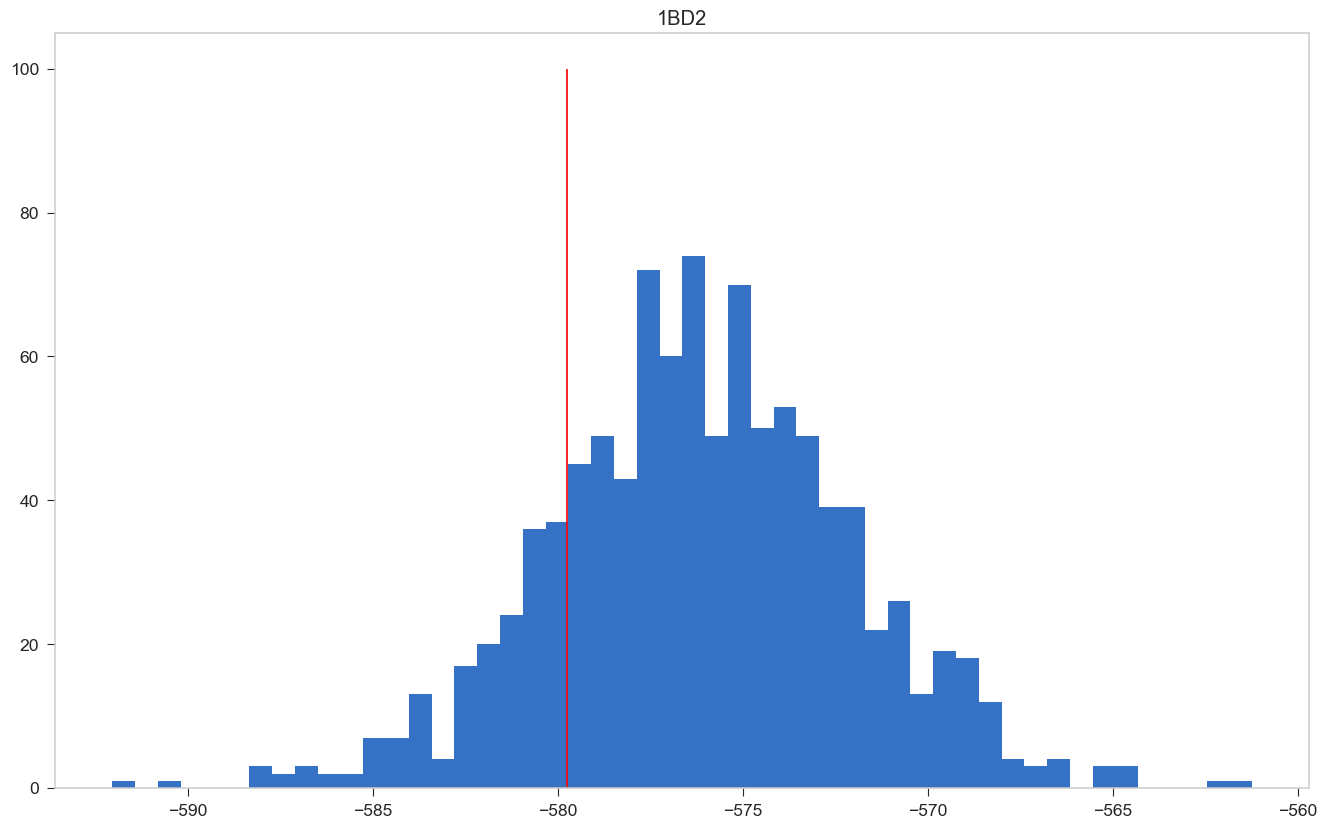

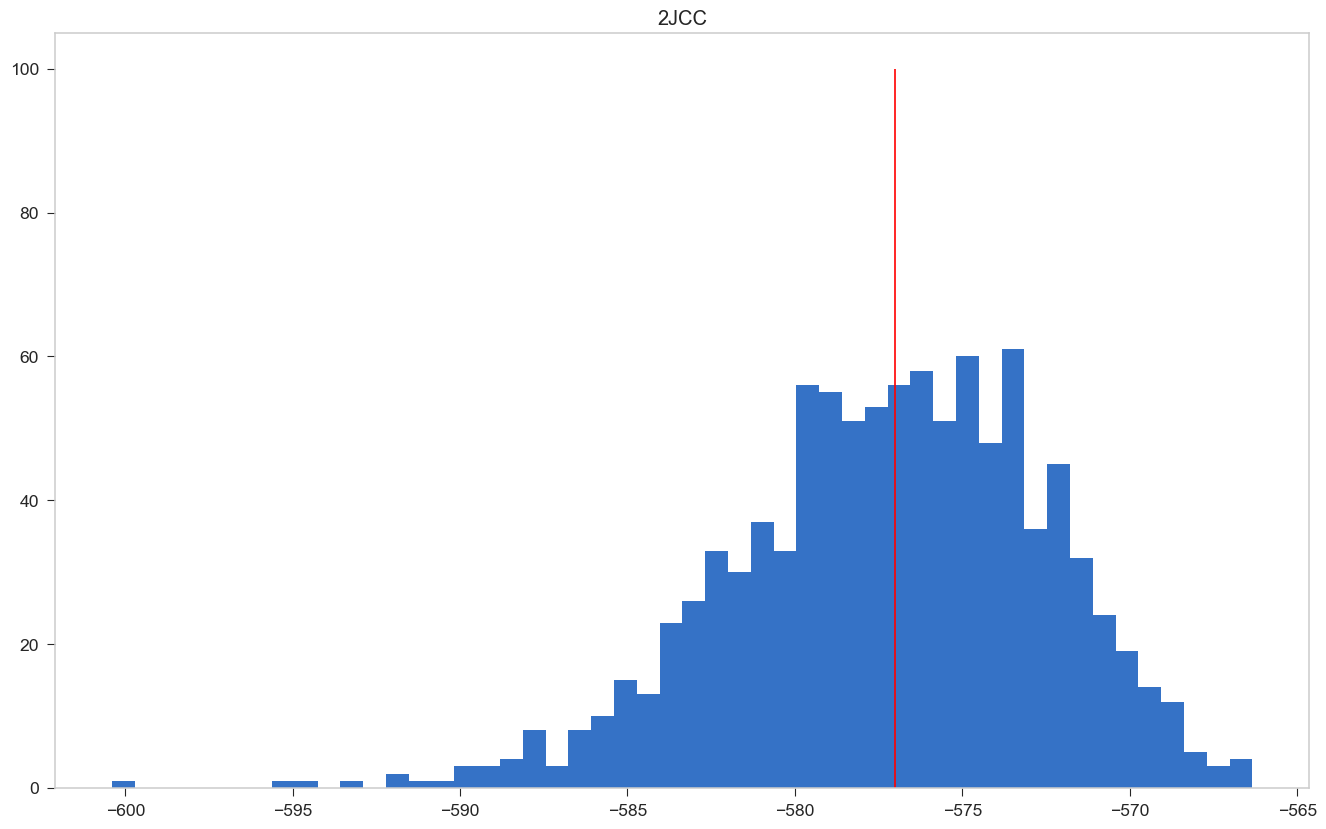

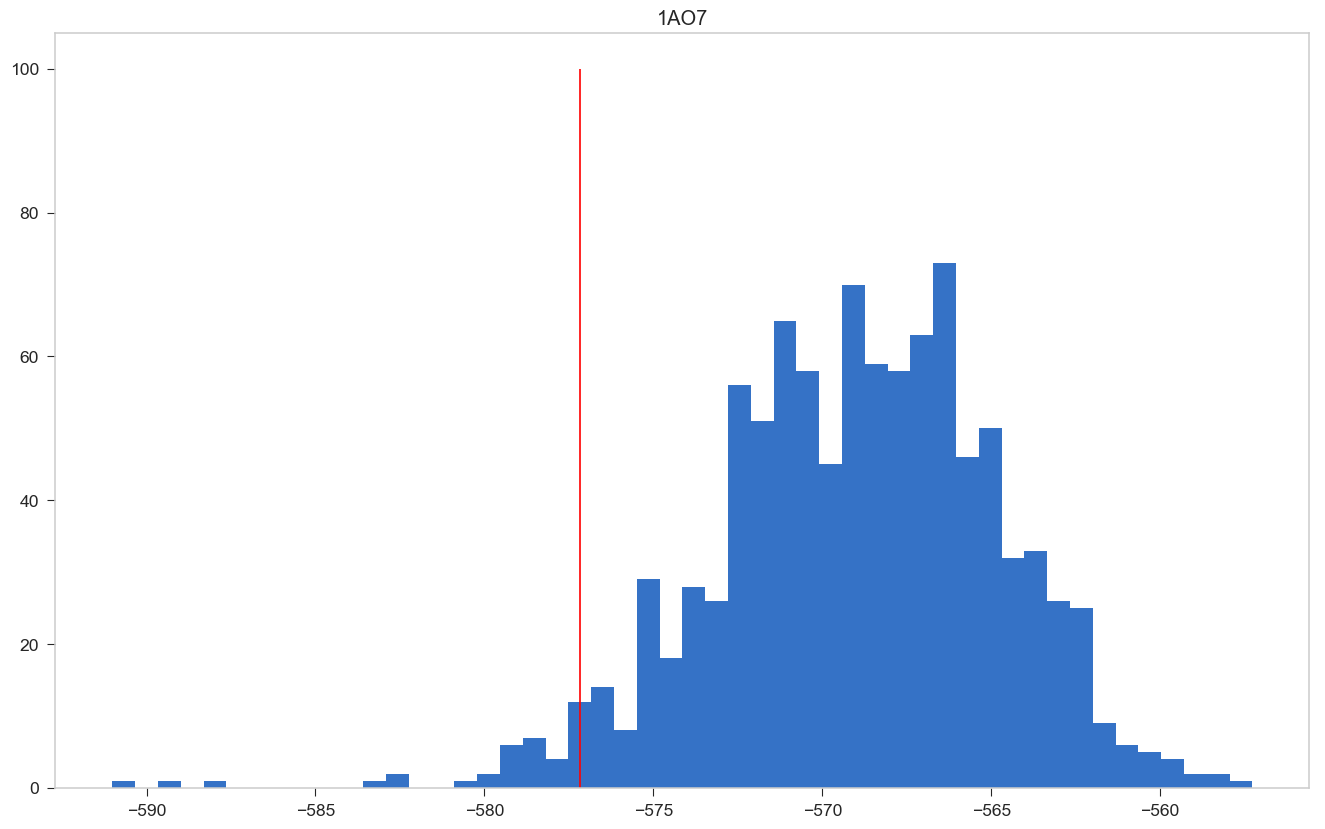

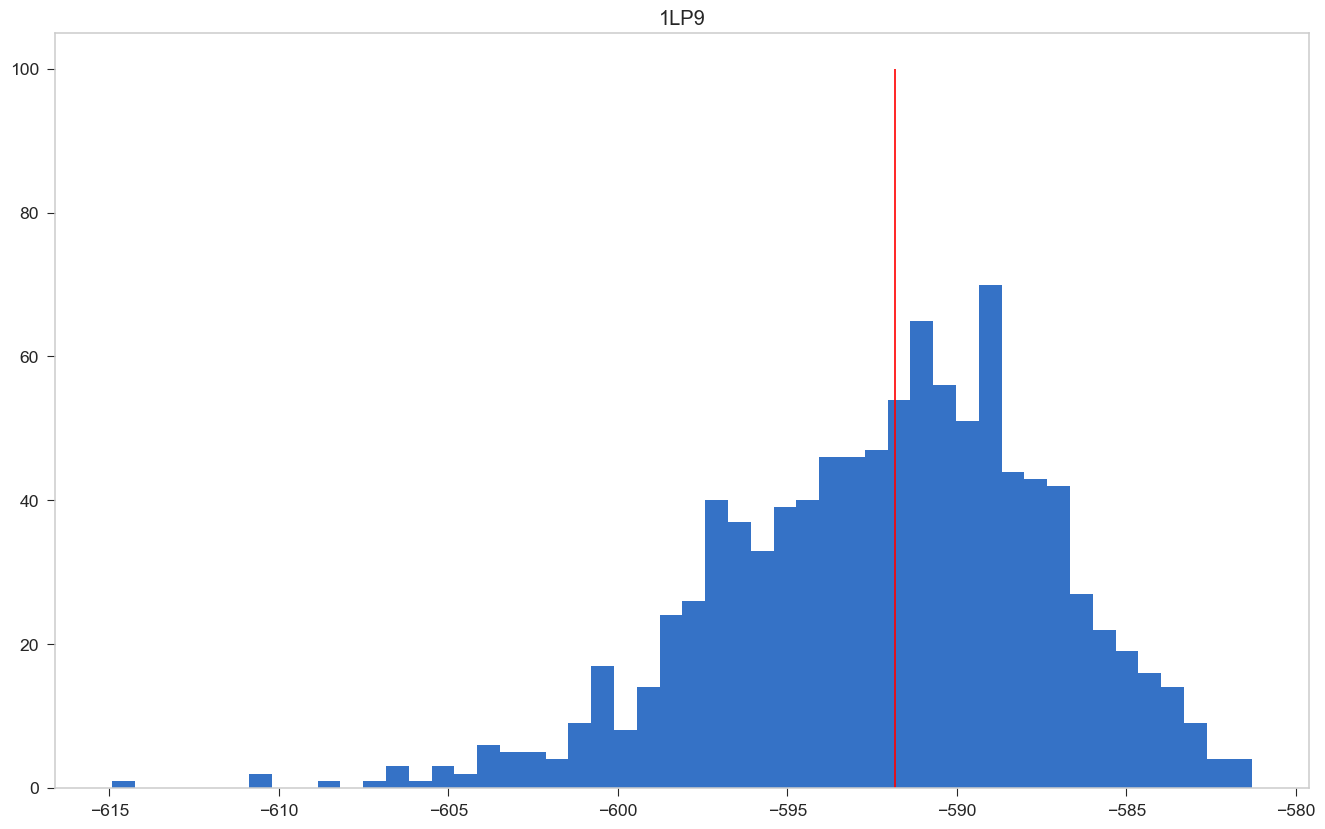

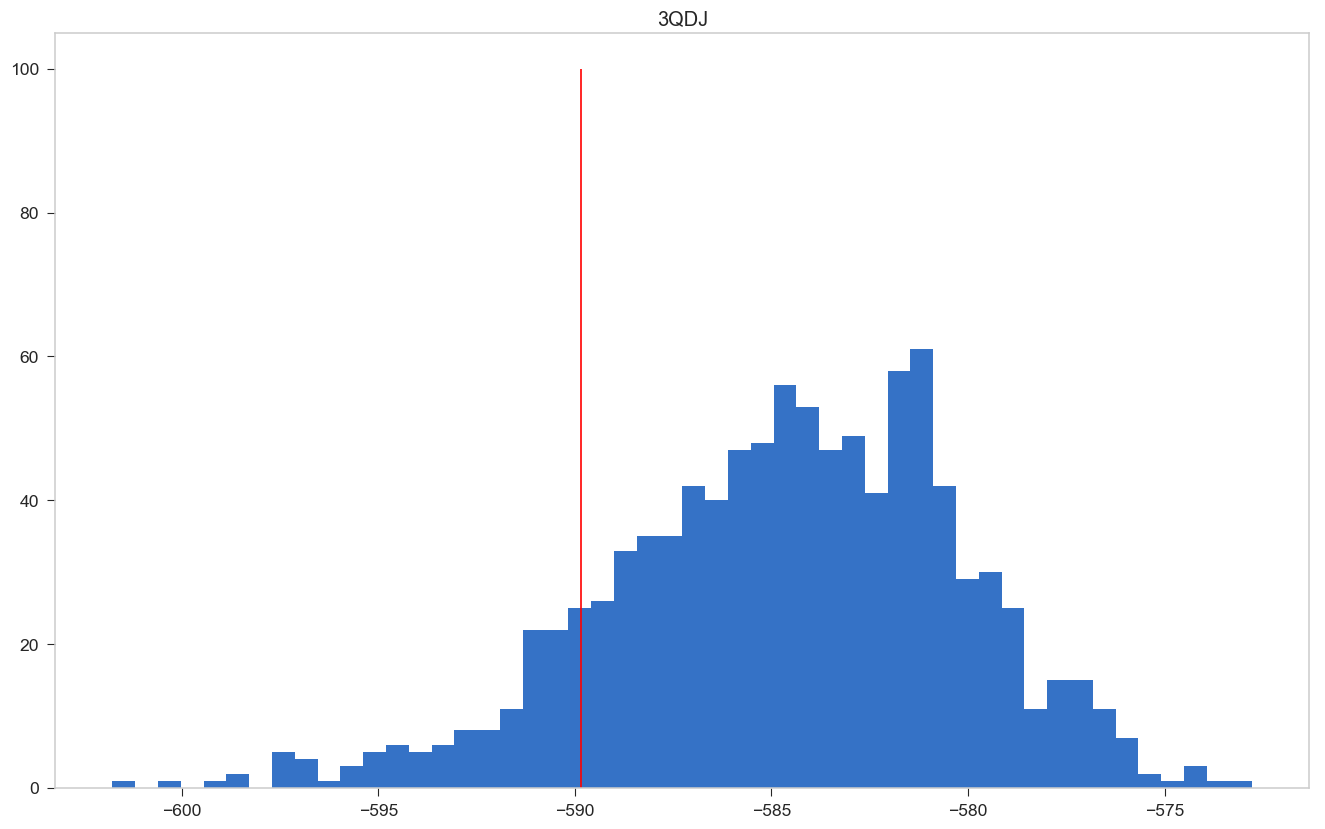

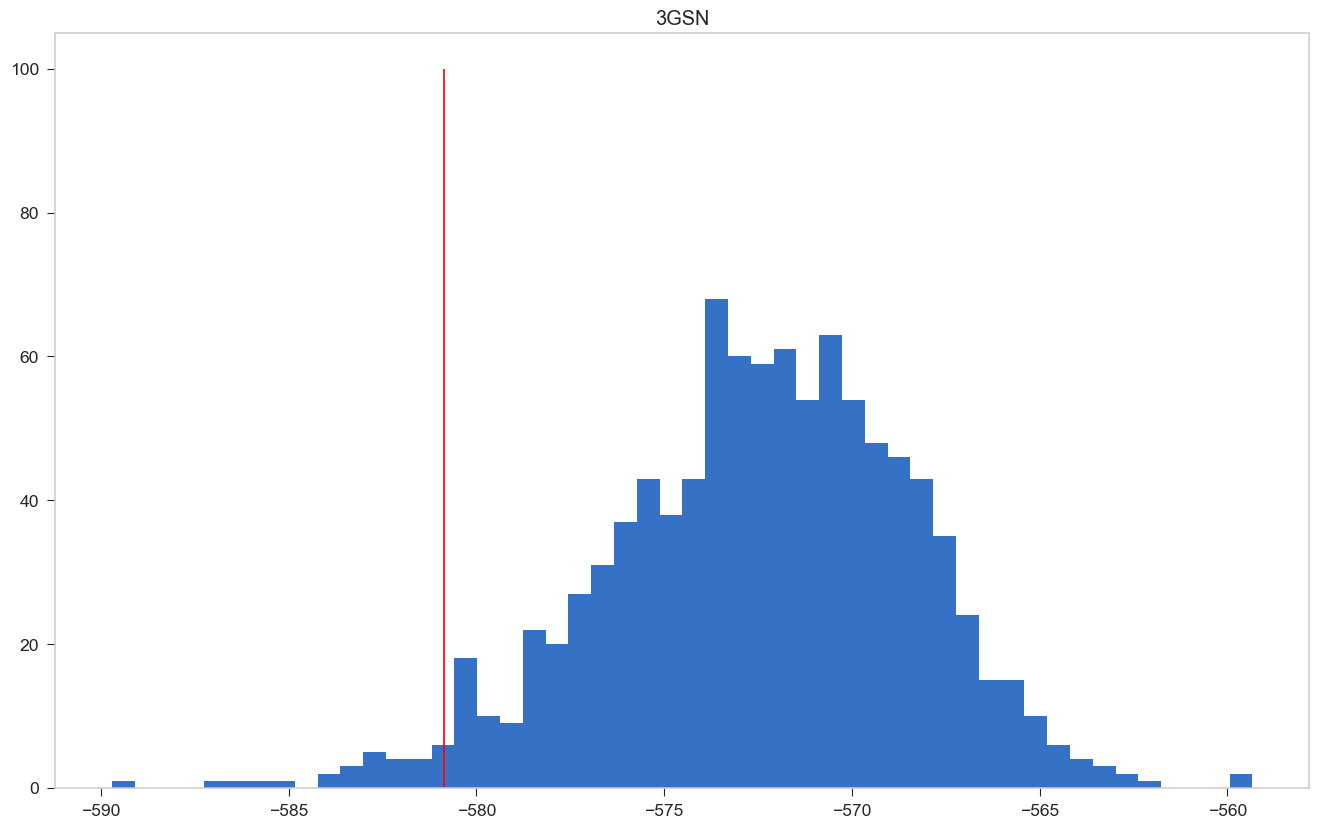

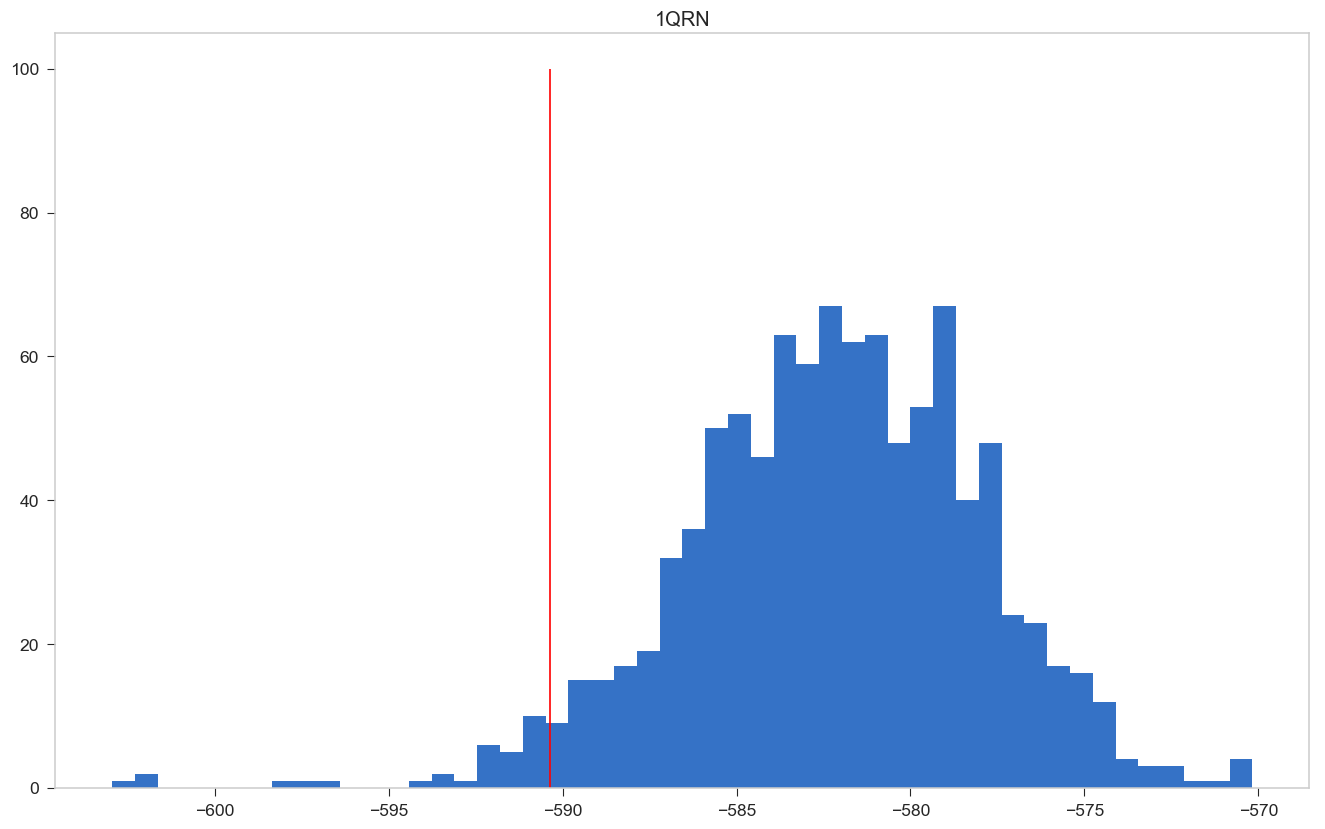

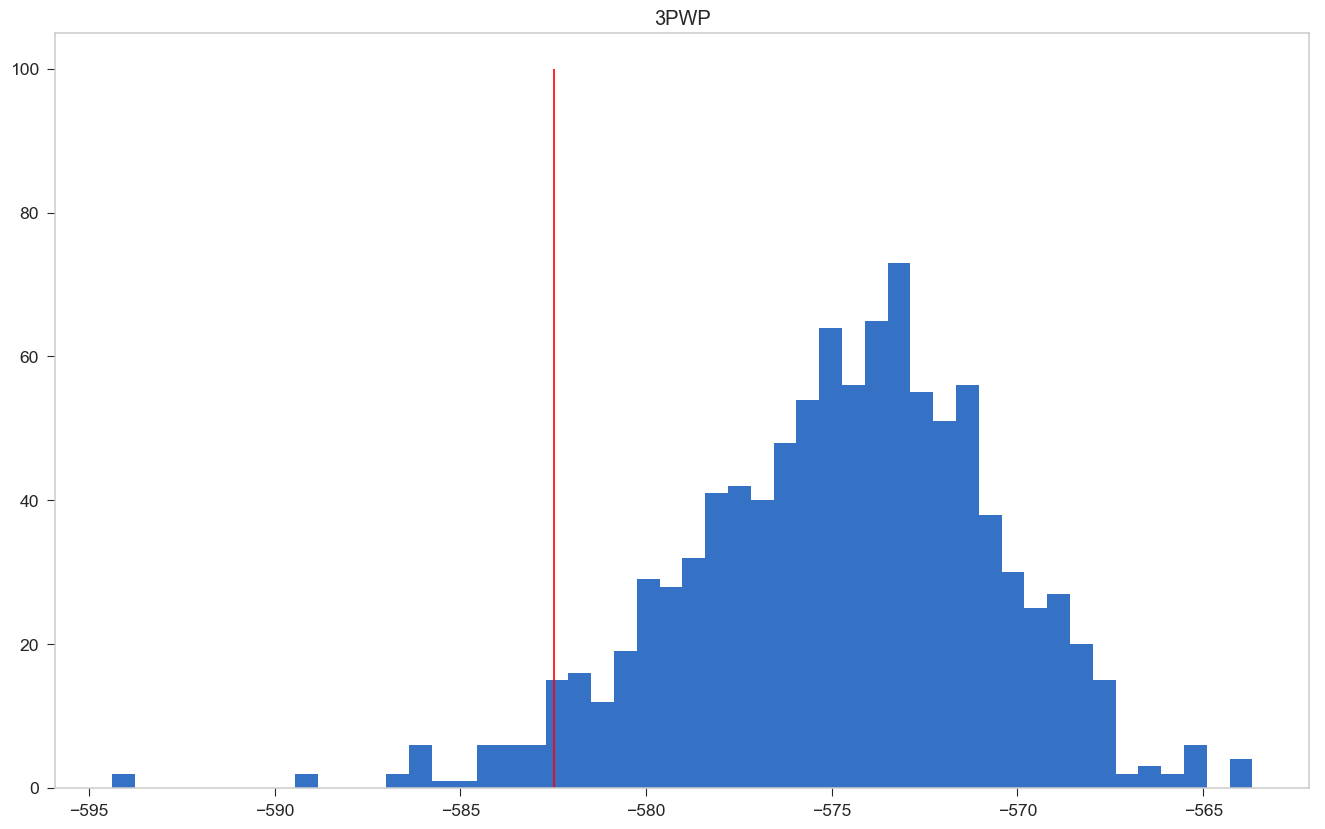

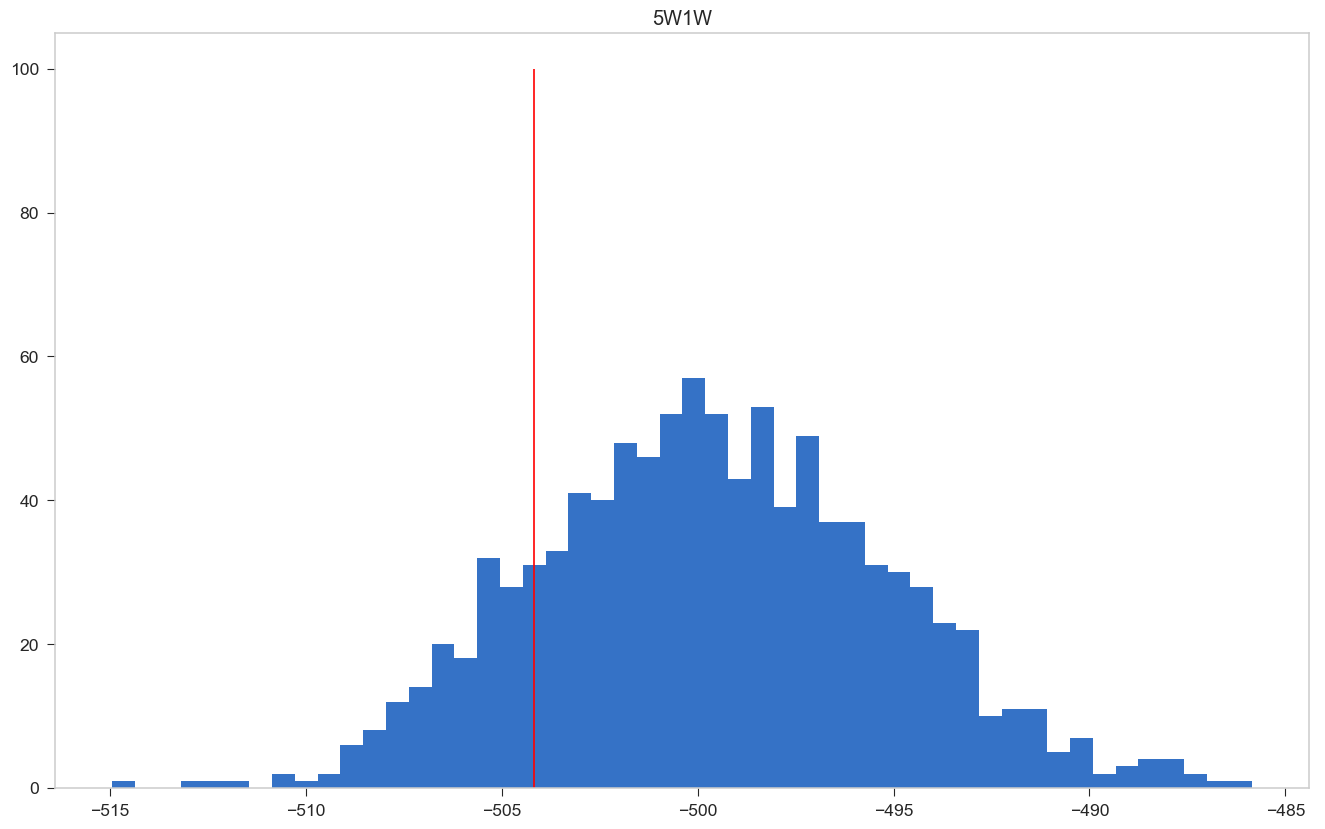

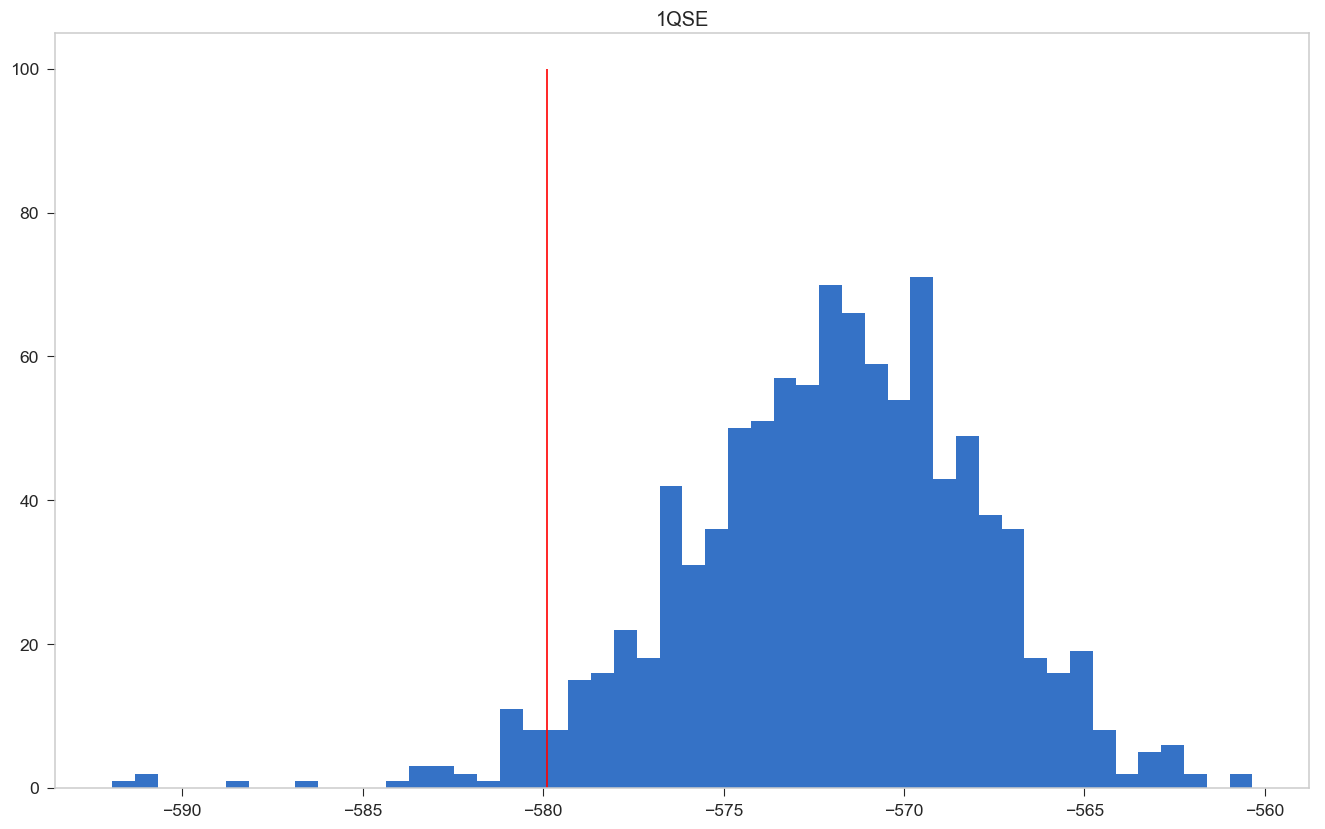

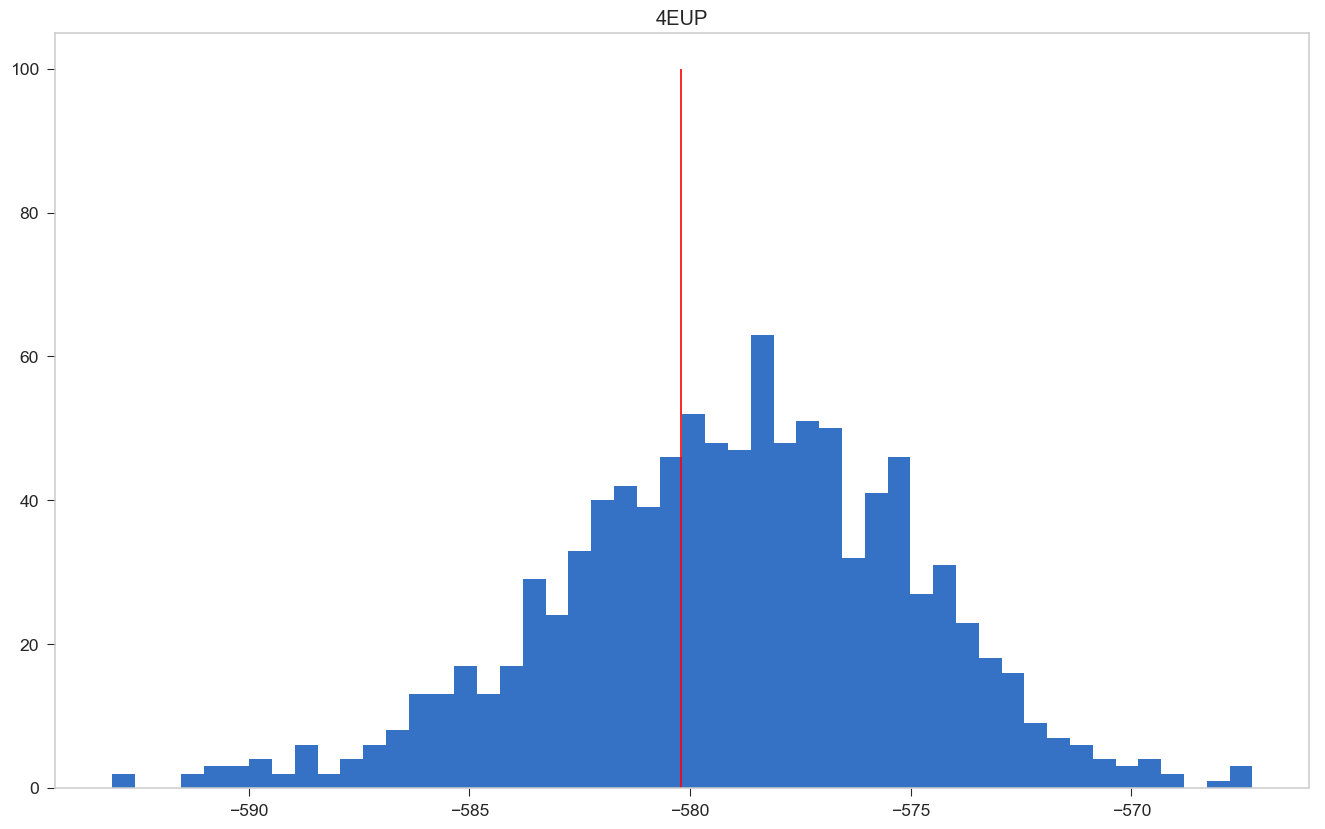

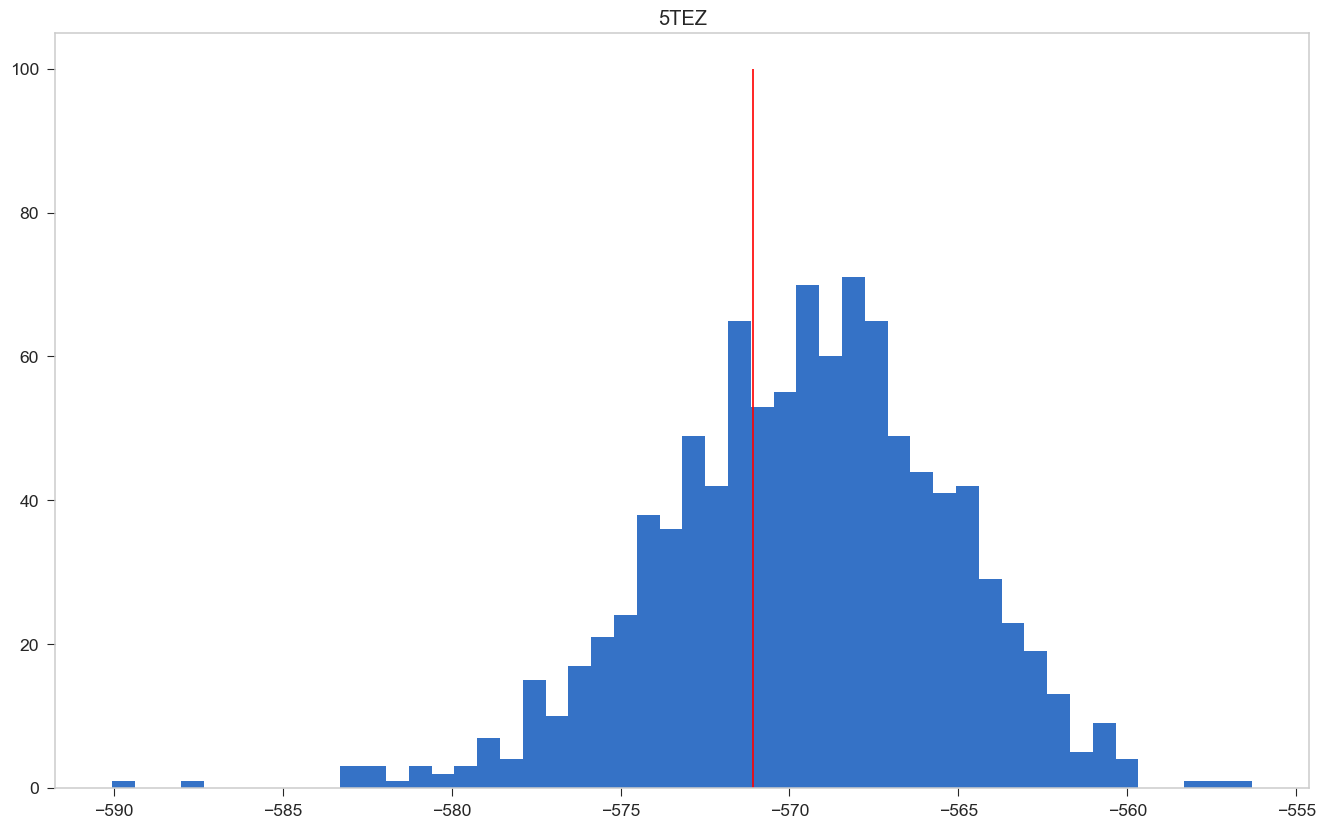

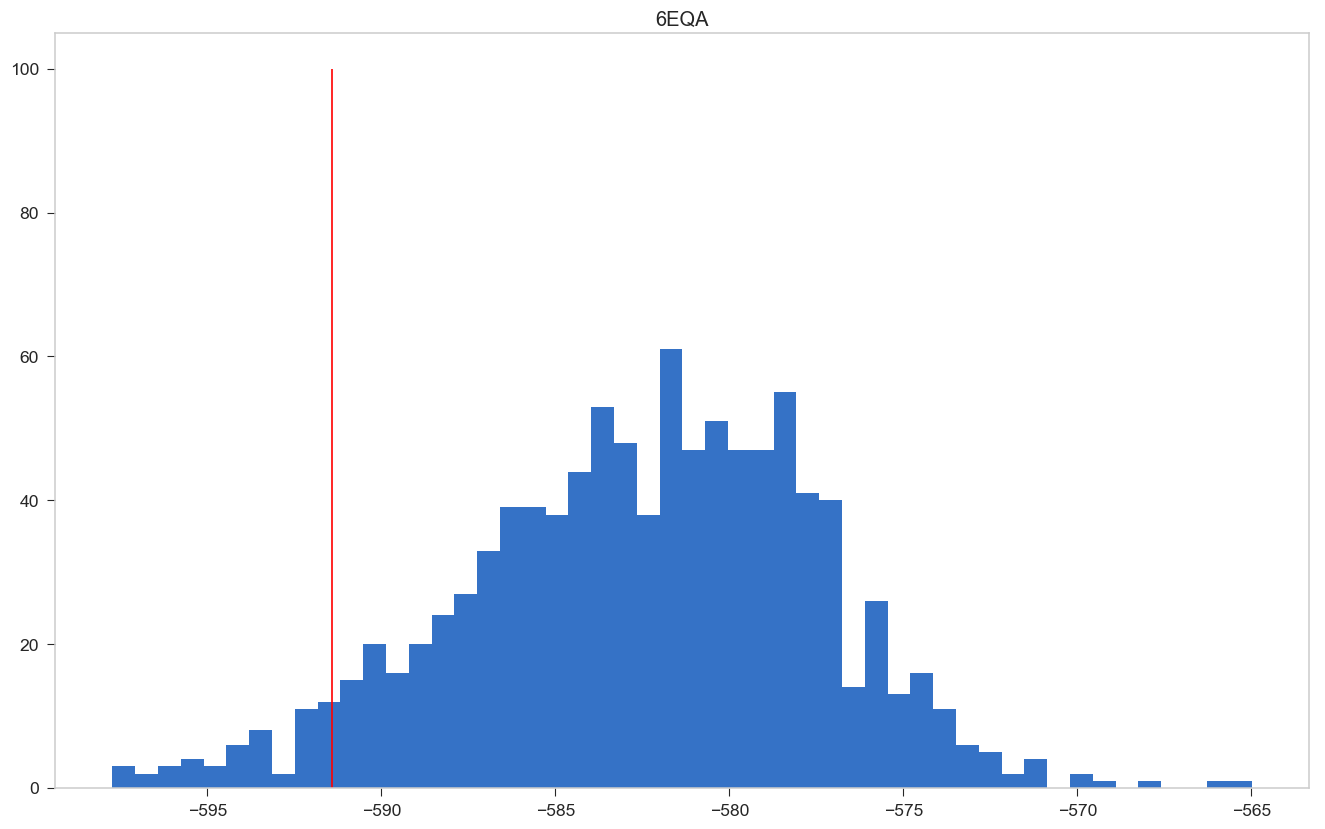

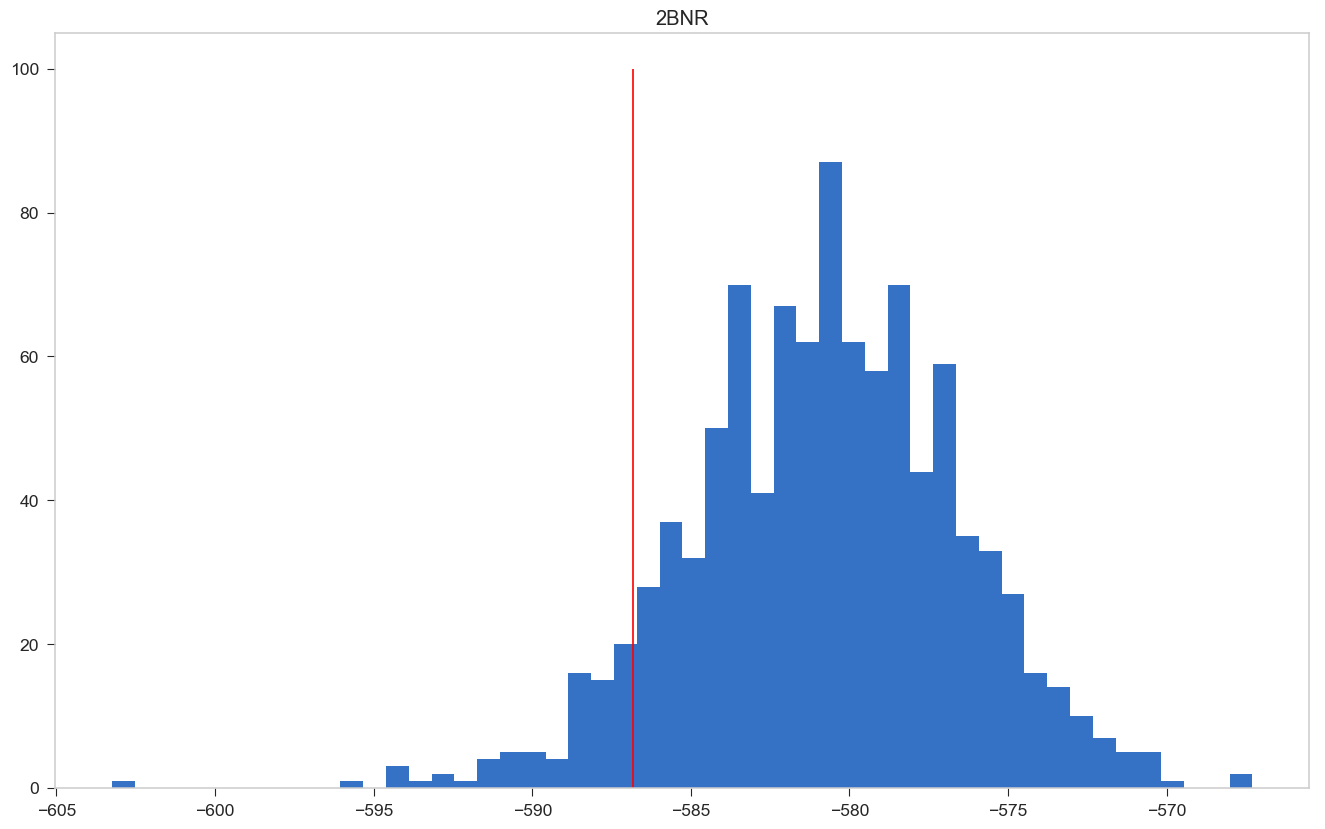

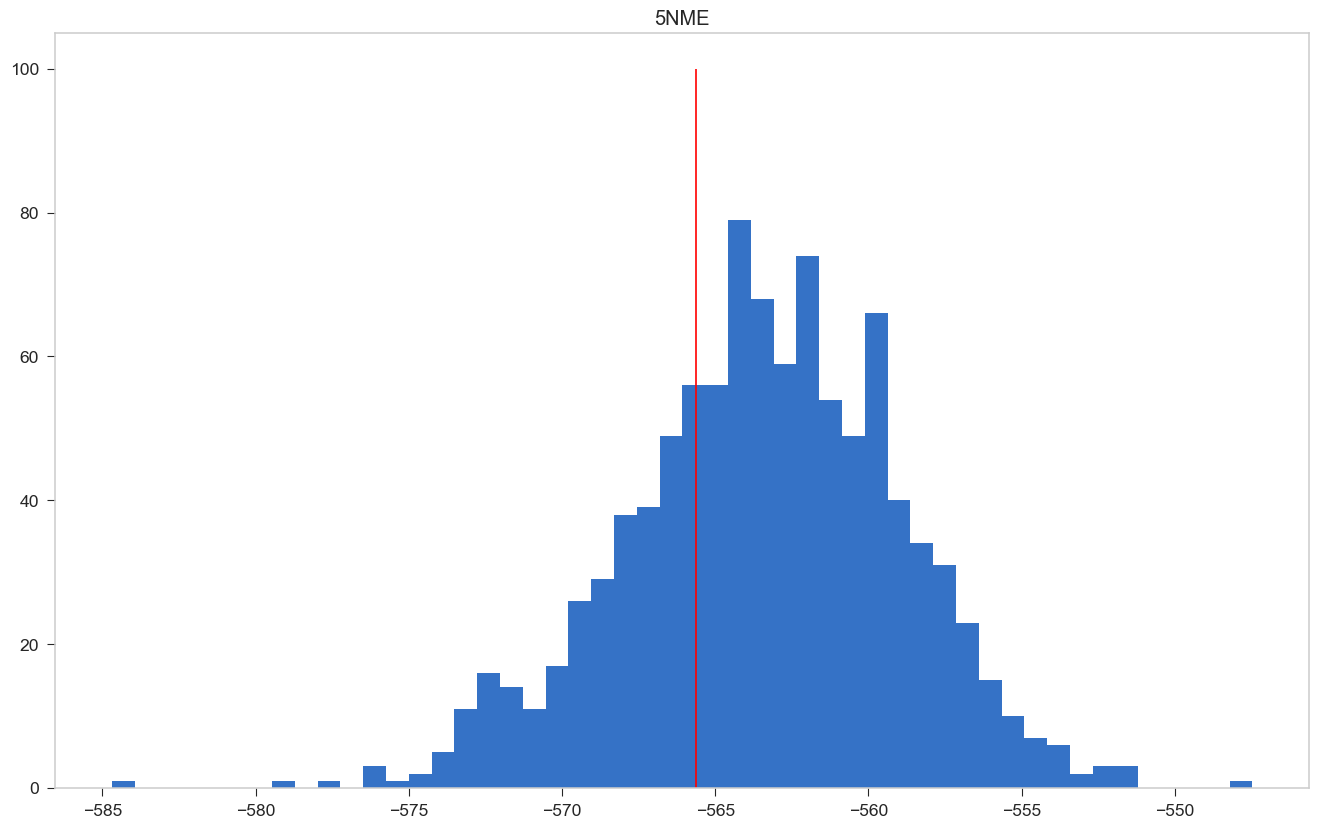

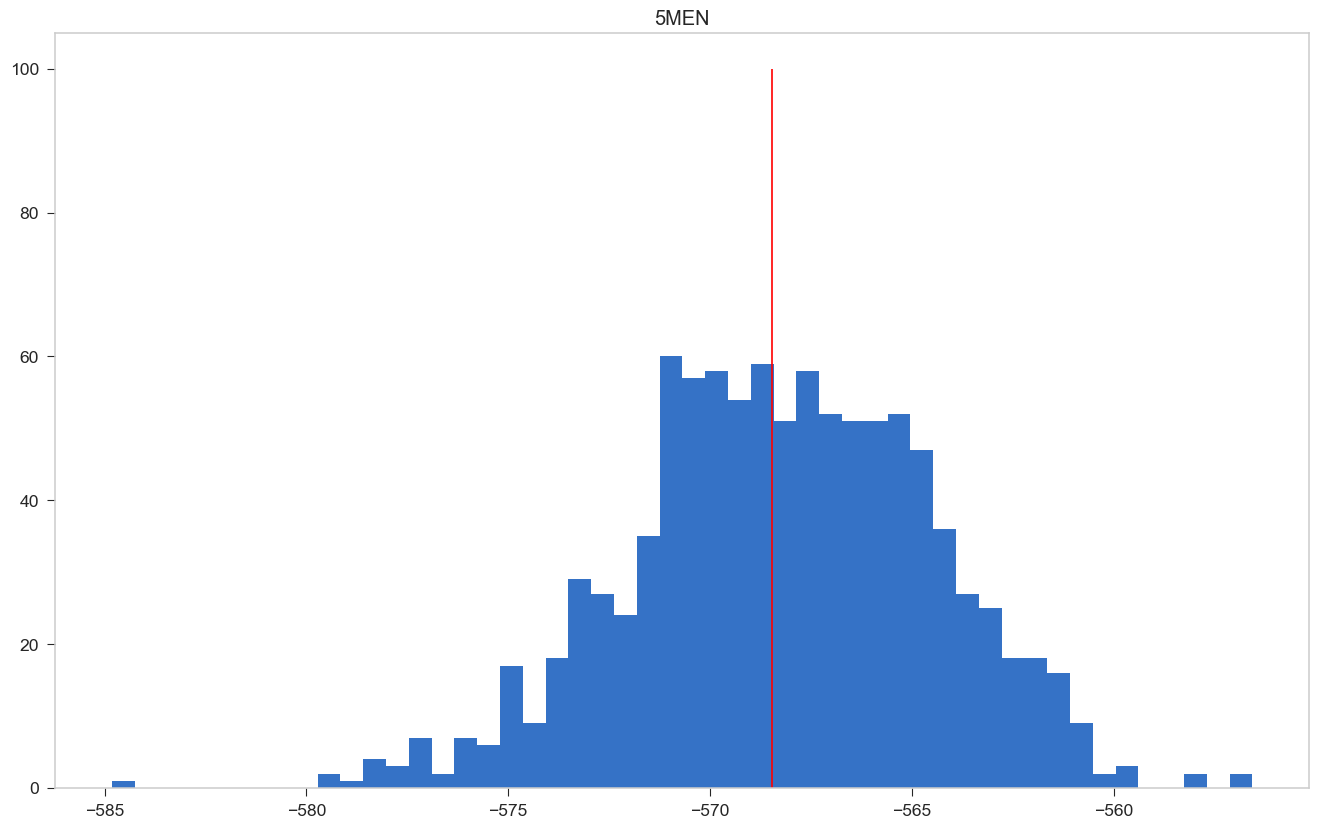

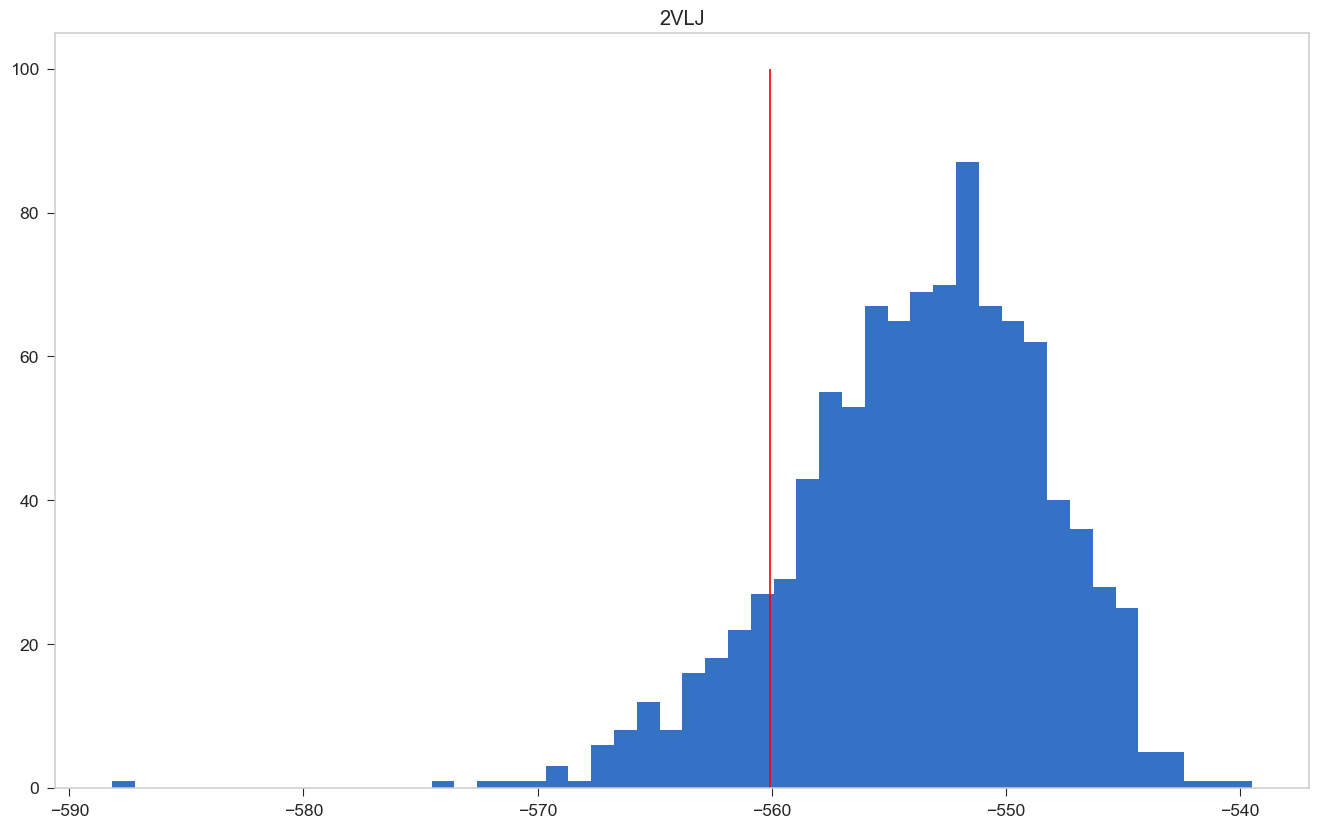

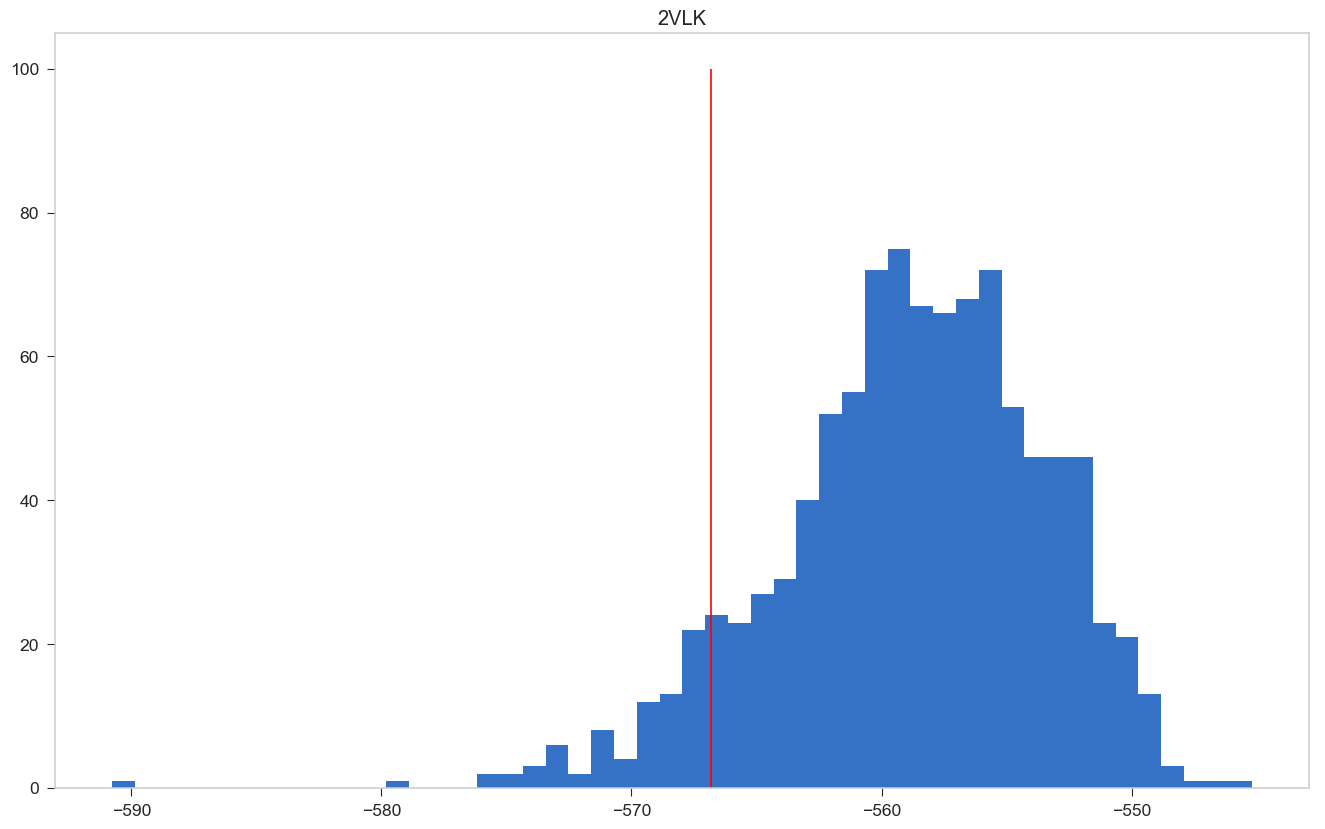

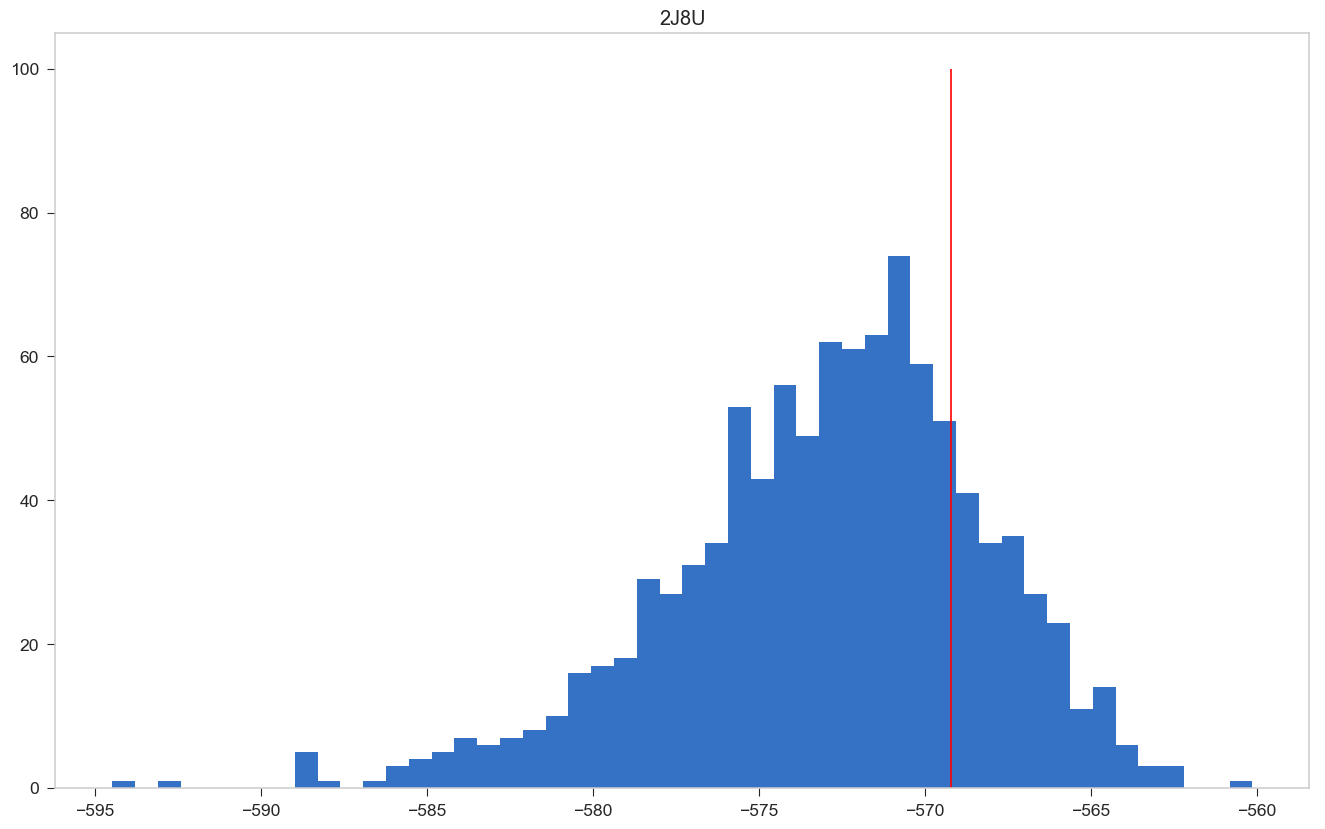

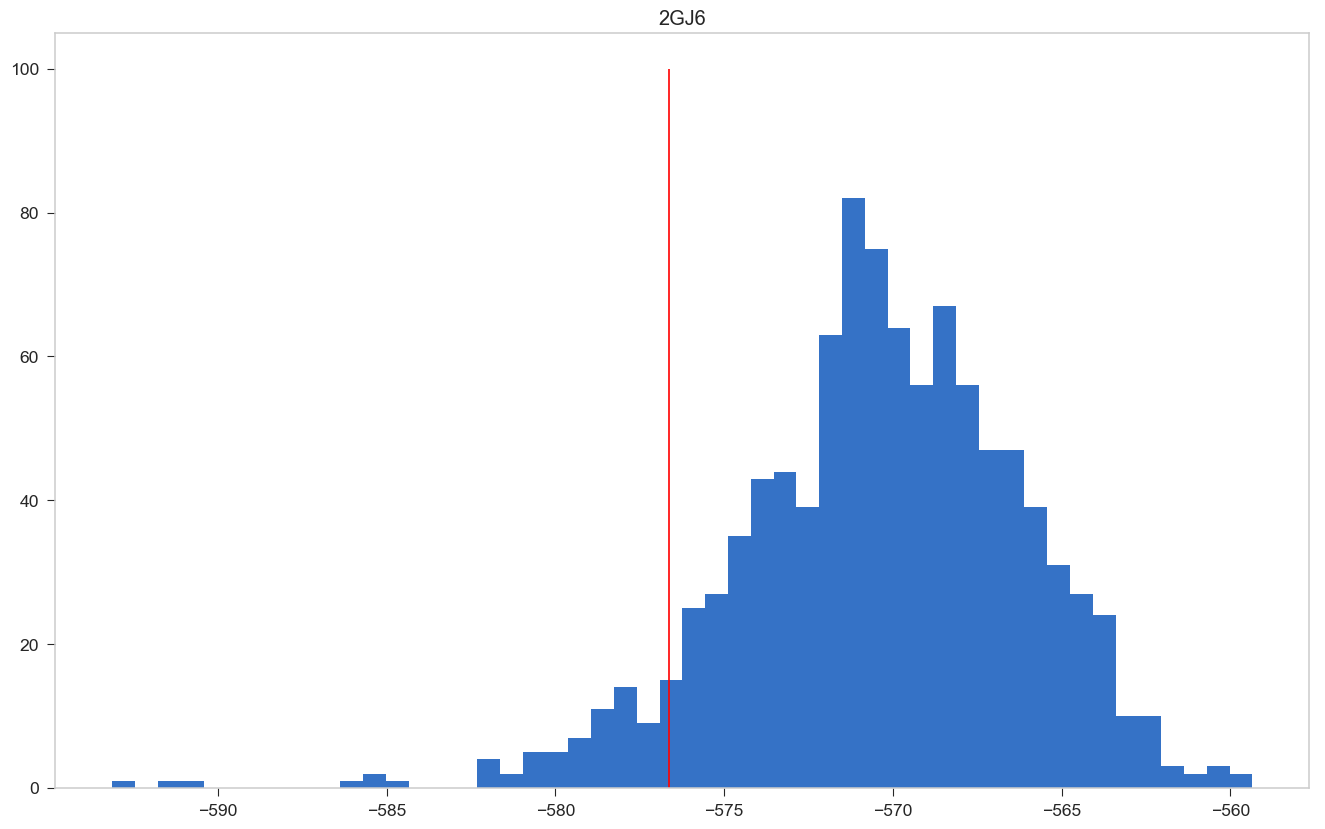

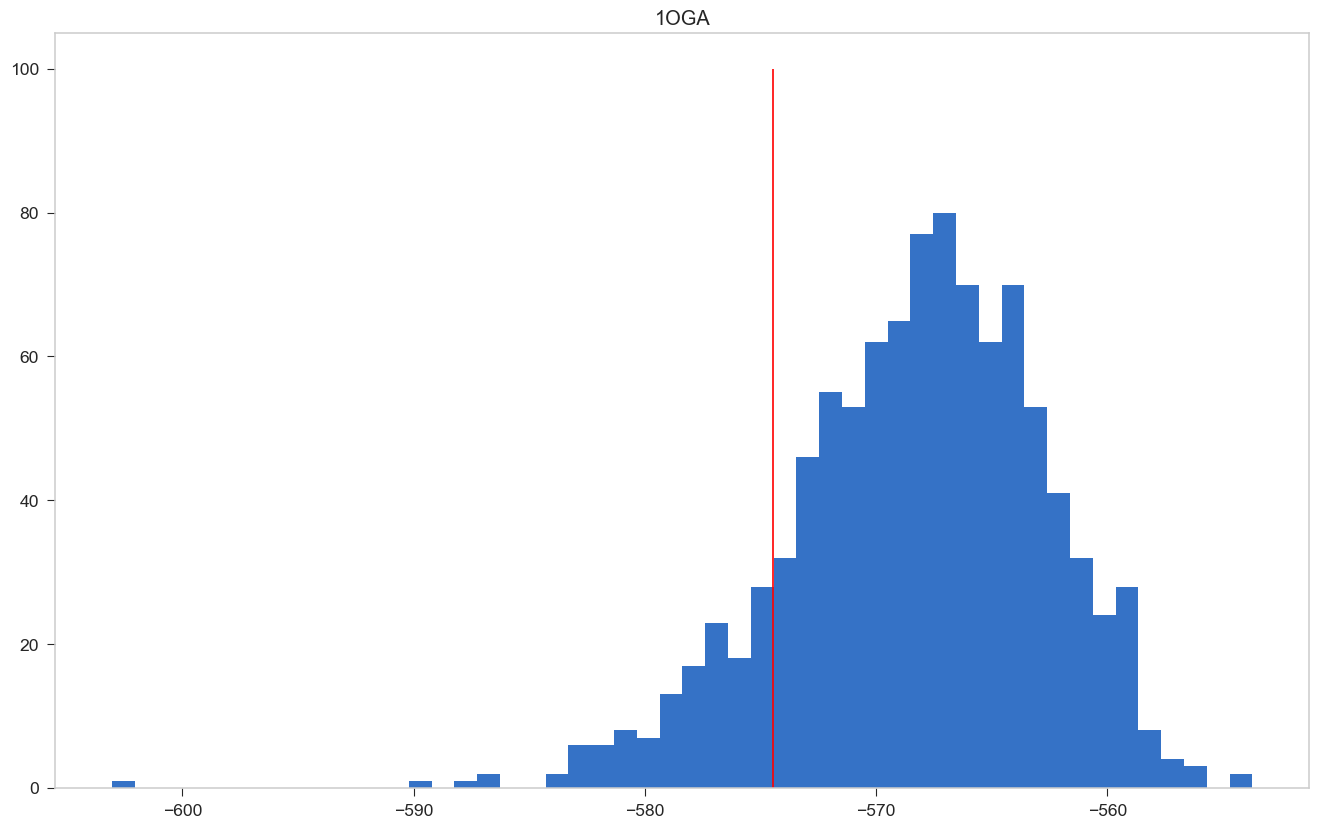

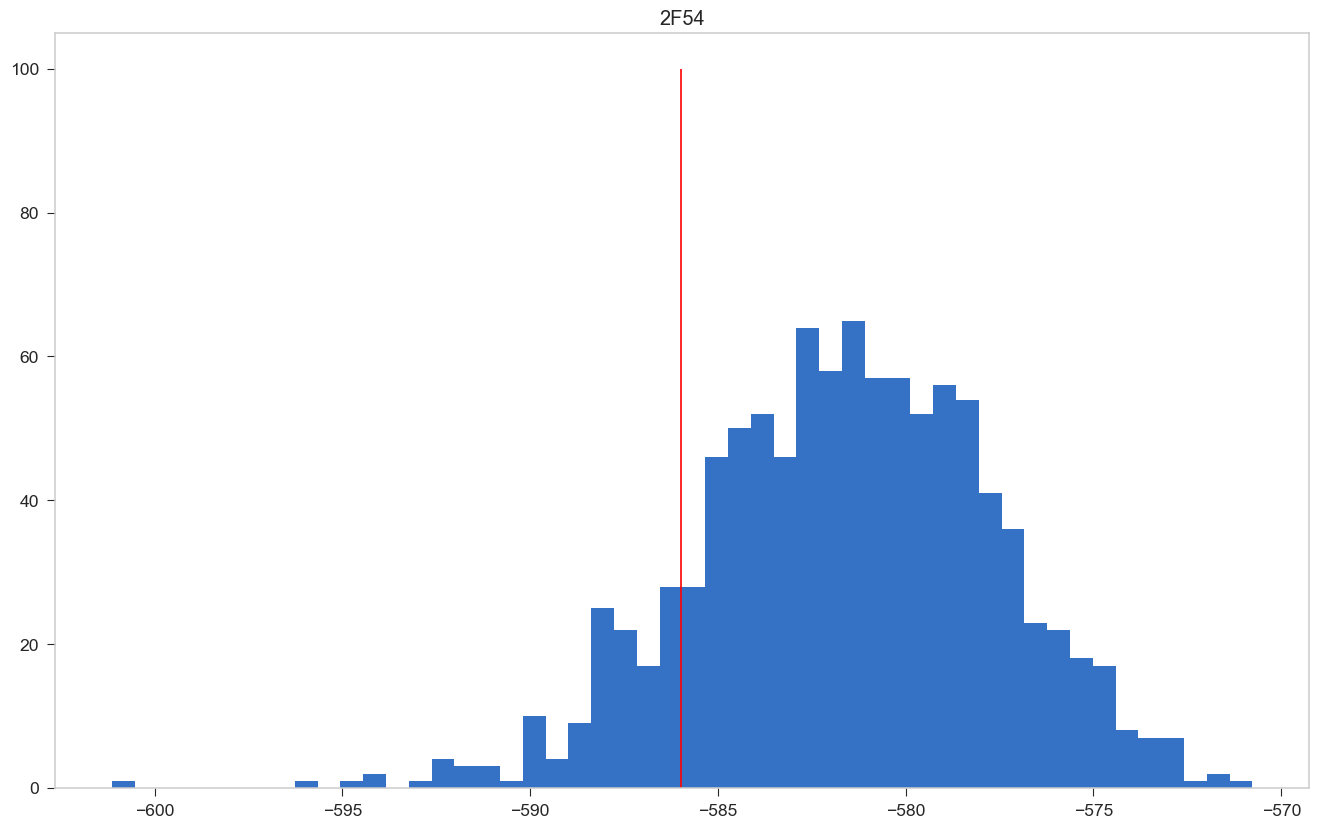

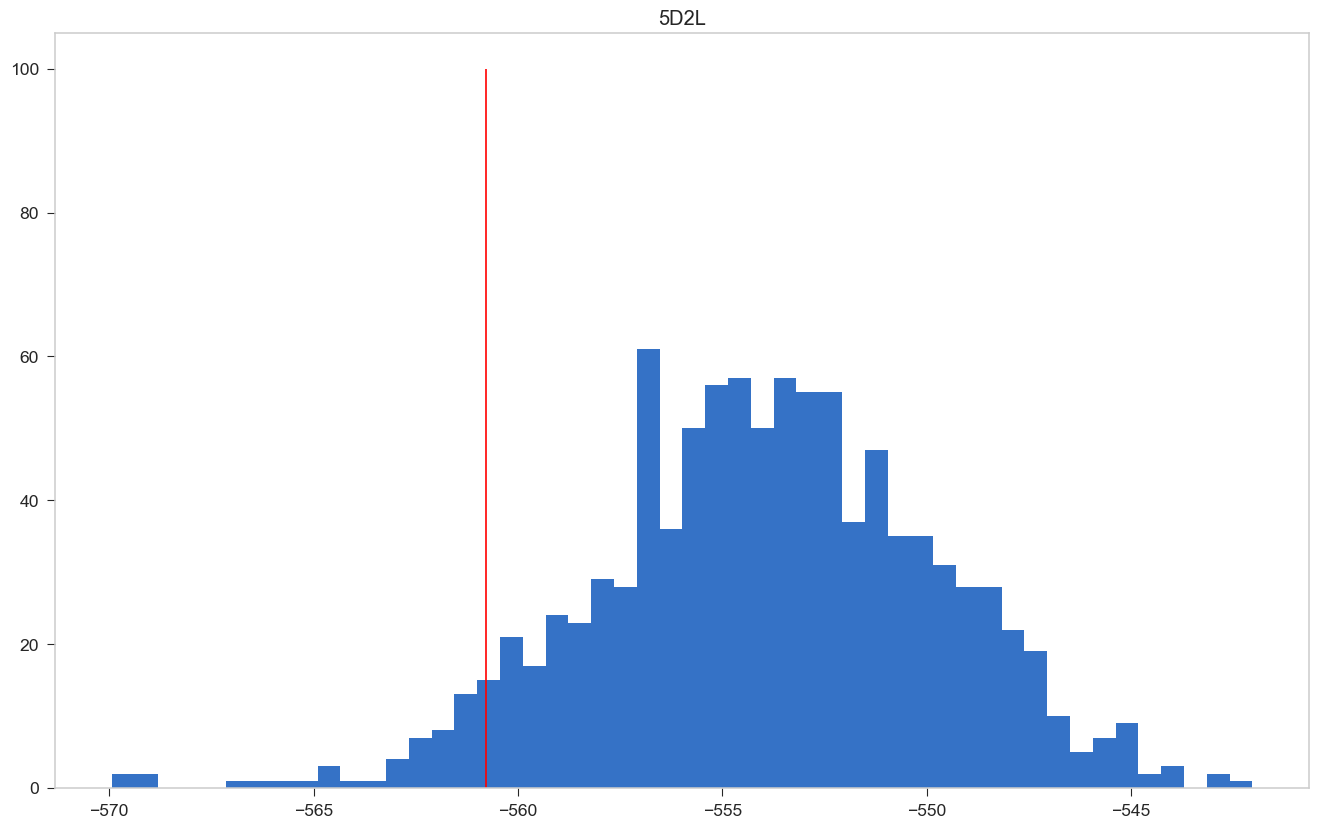

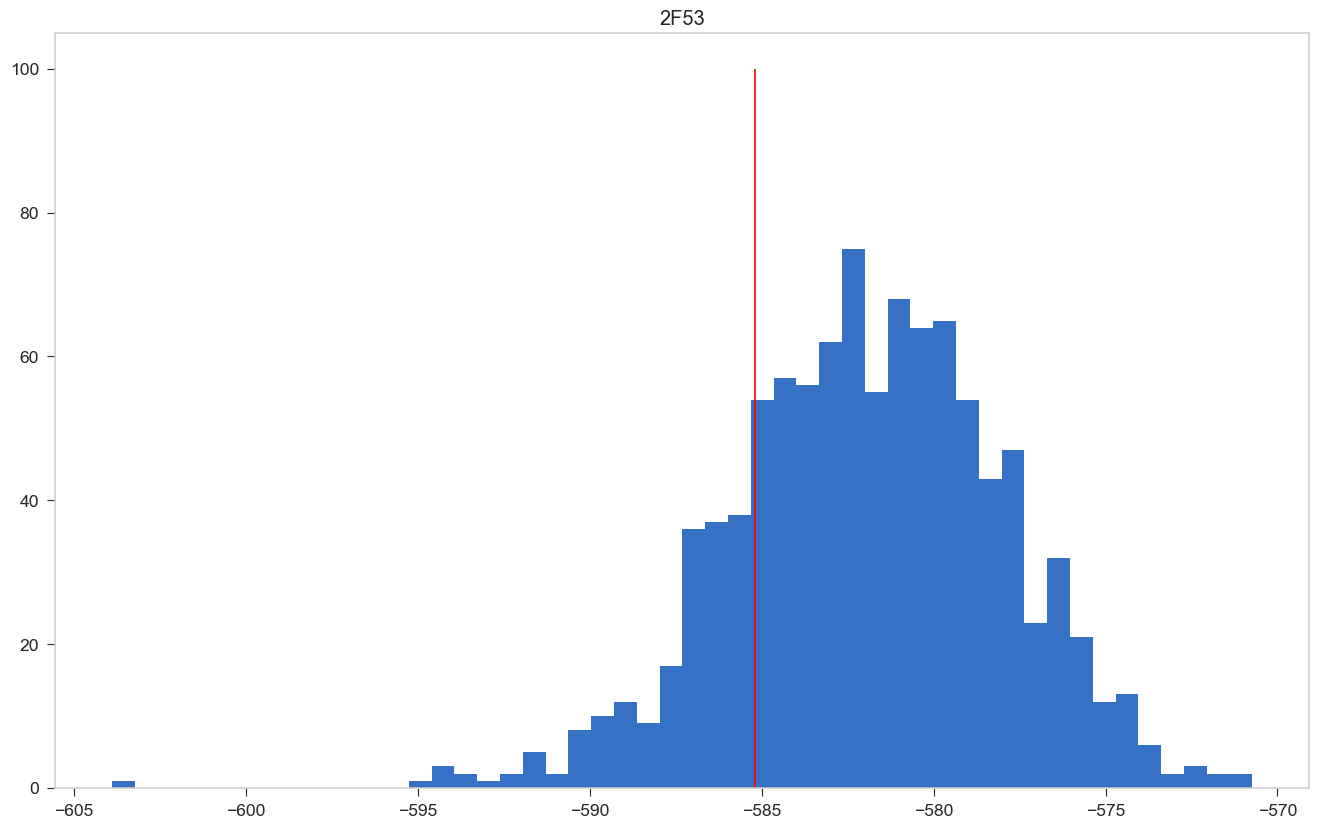

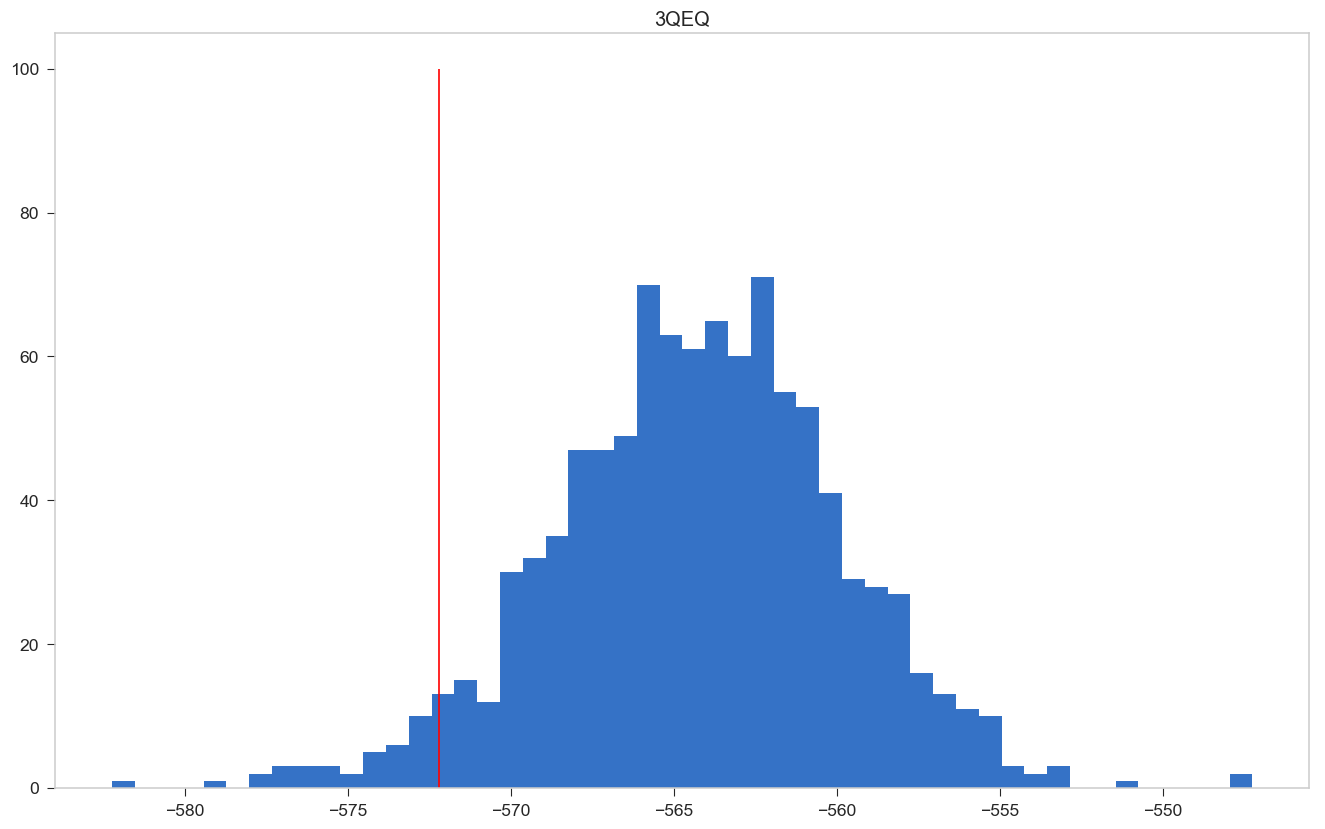

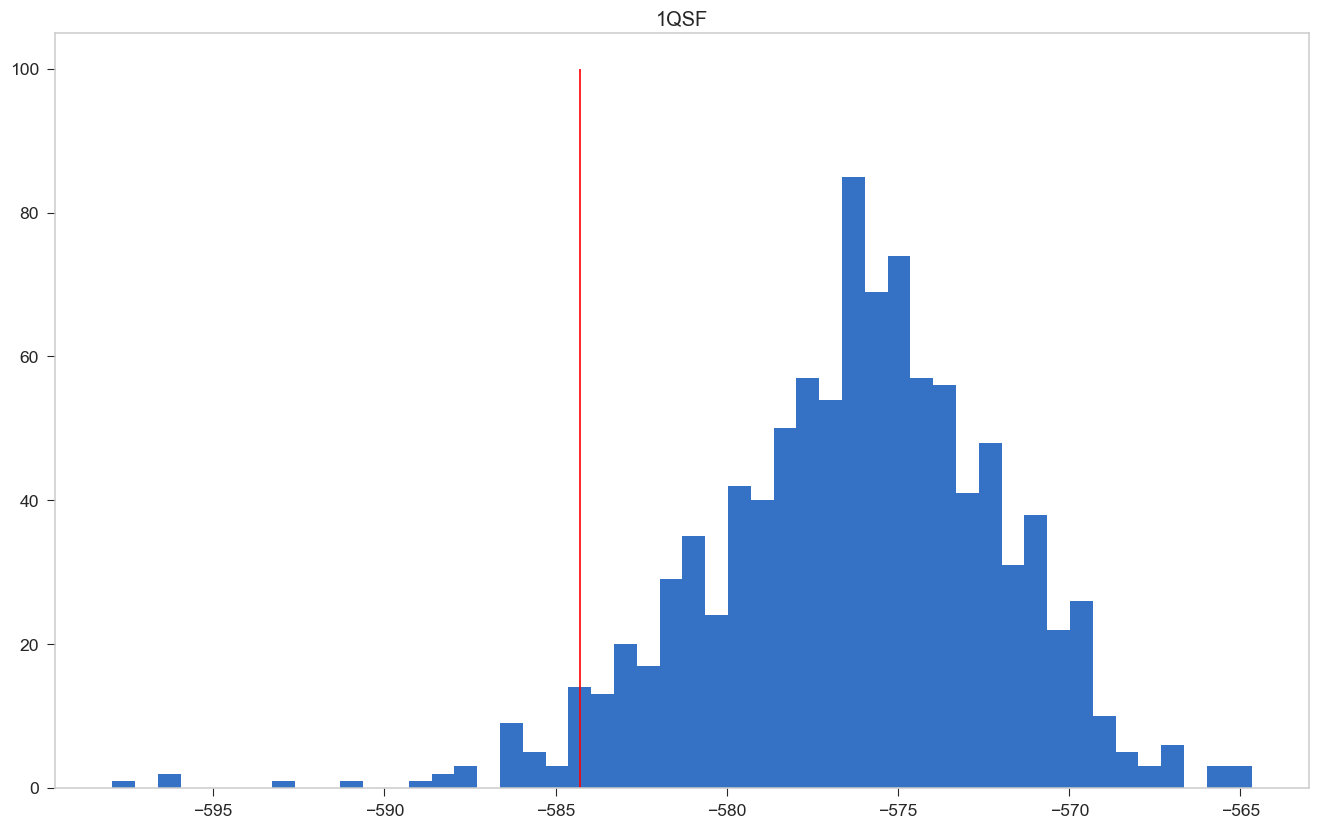

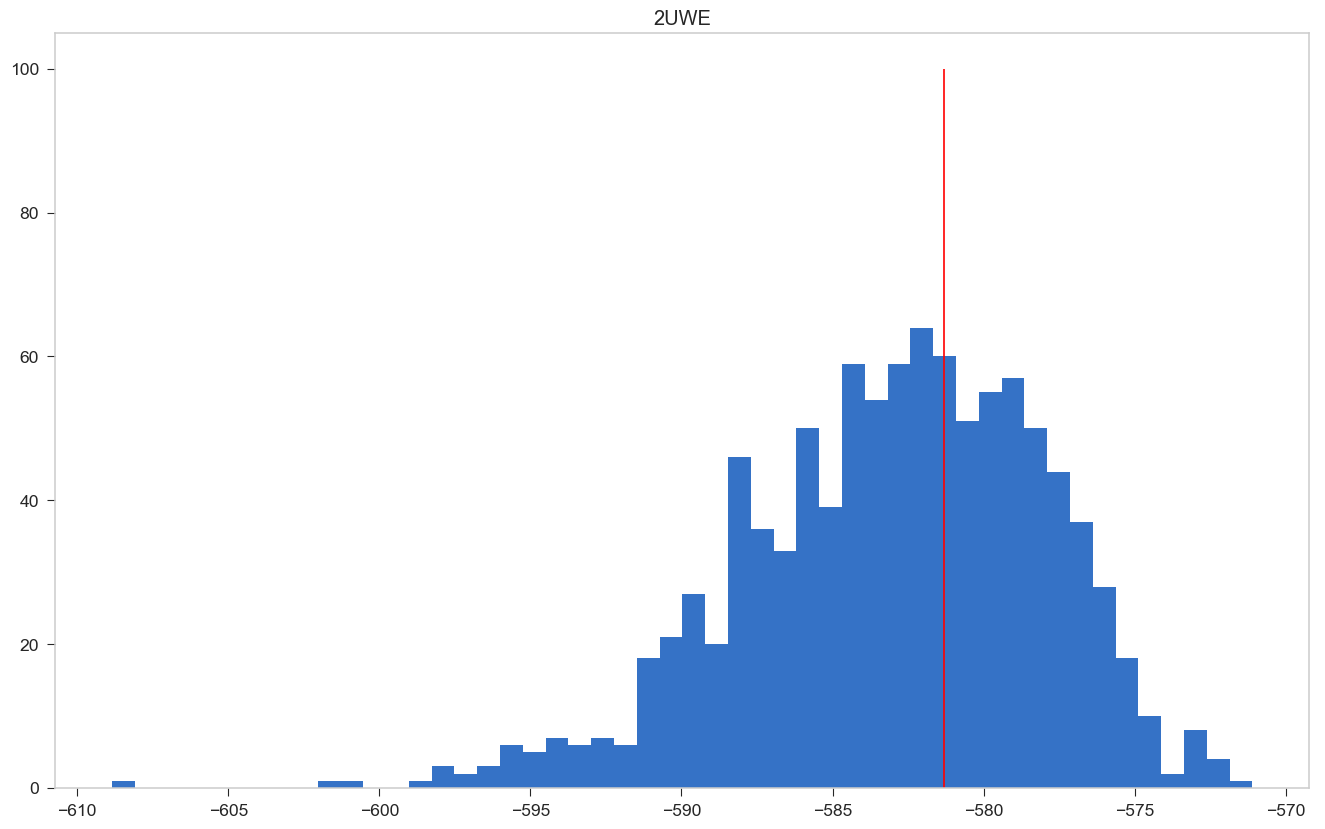

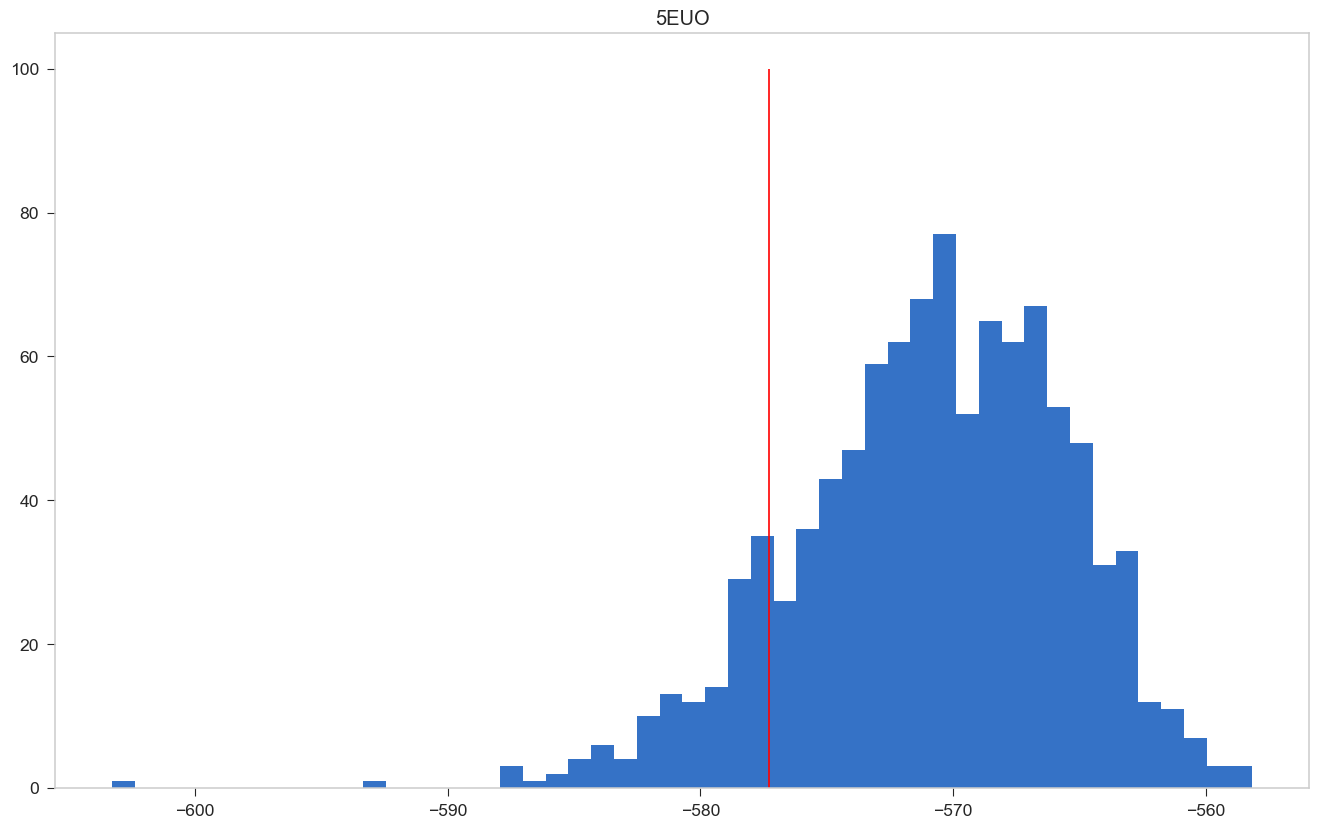

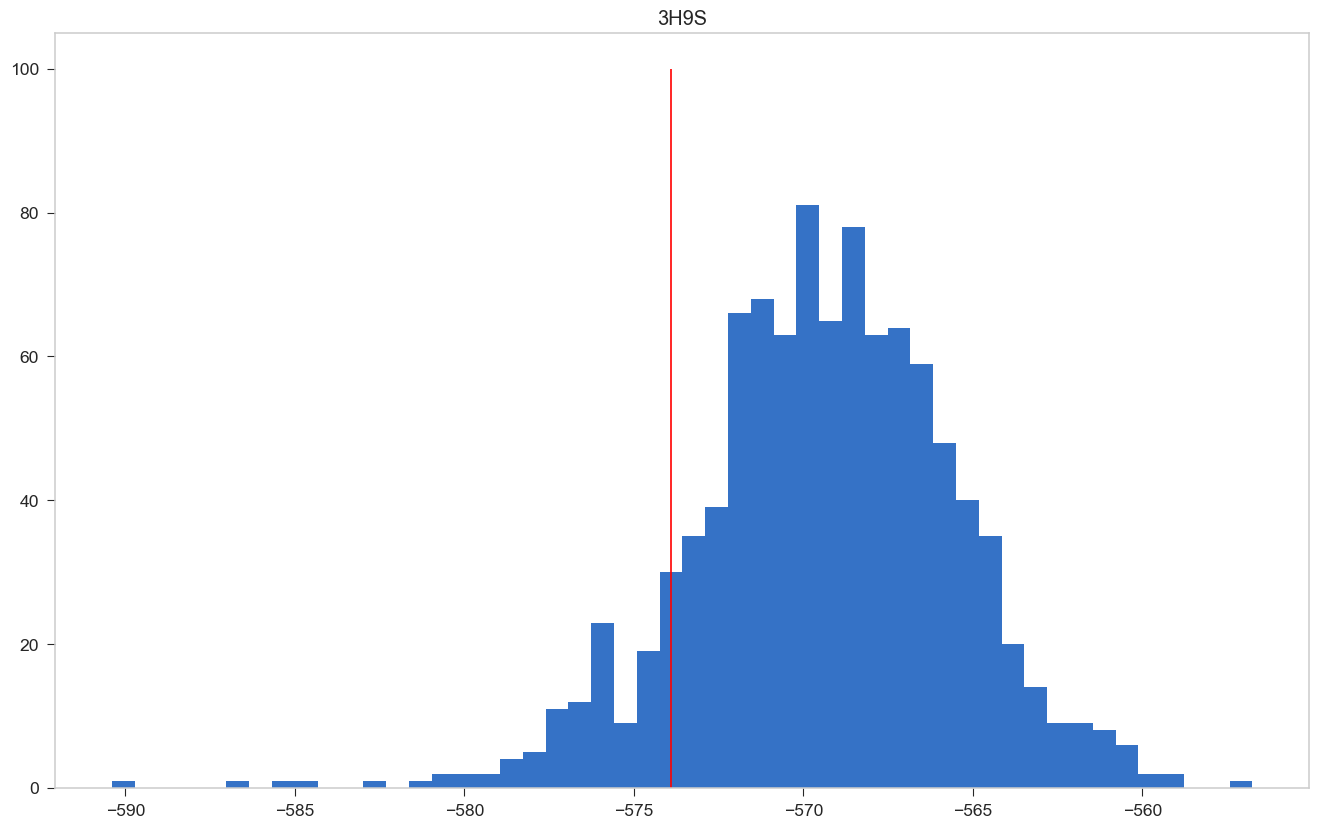

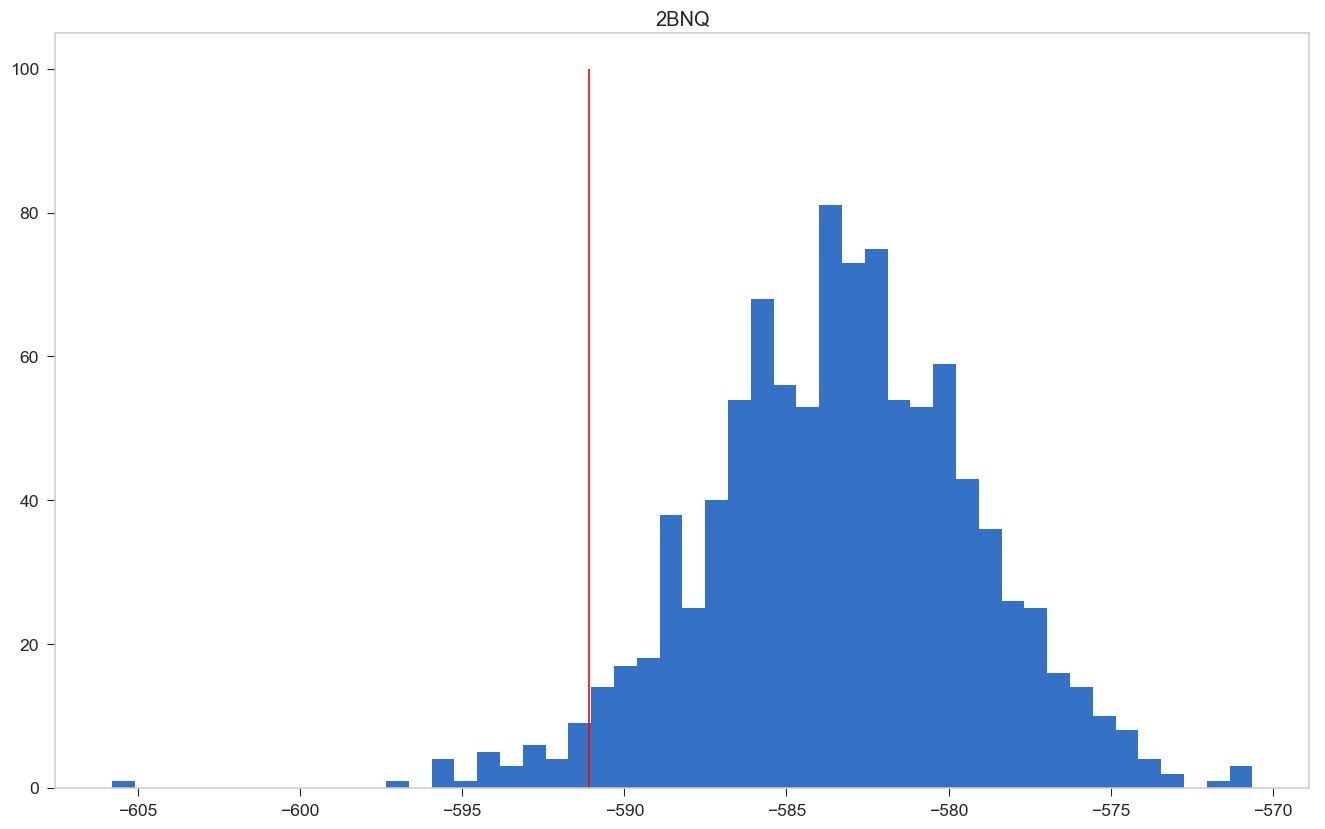

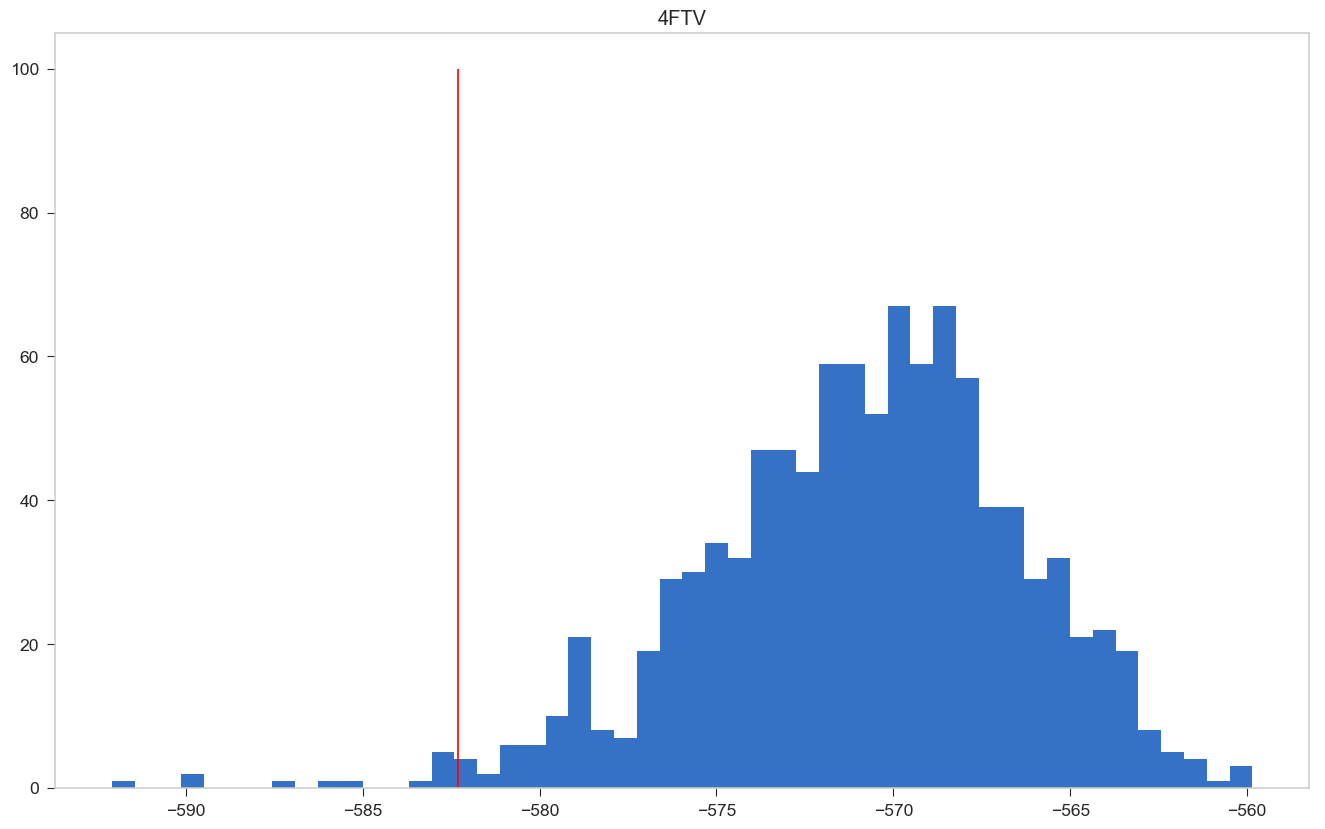

In [124]:
for name, e_native, e_decoy in zip(names, e_natives, e_decoys):
    # print(name)
    plt.figure()
    _ = plt.hist(e_decoy, bins=50)
    plt.vlines(e_native, ymin=0, ymax=100, color="red")
    _ = plt.title(name)
    plt.savefig(f"/Users/weilu/Dropbox/Optimization_Xfunnel/updated_figures/{name}.png")
    

In [125]:
os.chdir("/Users/weilu/Research/server/sep_2019/peptide_optimization_trial_4_duplicate/optimization/")
# gamma_file_name = "gamma_iter1_combined_mar06.dat"
# gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/cutoff100"
gamma_file_name = "/Users/weilu/Research/server/sep_2019/saved_gammas/trial_4_cutoff100_impose_Aprime_constraint"

data = validate_hamiltonian_wei("phi_list.txt", "protein_list", gamma_file_name, "shuffle", 1000, mode=0)
data


0 3.508959112034475


,Protein,Z_scores,E_native,E_mgs,Std_mg
0,1BD2,3.508959,-590.408659,-576.119892,4.072082
1,2JCC,6.406843,-607.314444,-577.222713,4.696811
2,1AO7,5.530768,-592.327551,-569.008721,4.216201
3,1LP9,6.310993,-622.609479,-592.084044,4.836867
4,3QDJ,4.901757,-606.525572,-584.644281,4.463969
5,3GSN,1.854756,-580.017867,-572.453867,4.078164
6,1QRN,4.838191,-602.786617,-582.219358,4.251023
7,3PWP,6.154082,-600.250600,-574.765083,4.141238
8,5W1W,1.467168,-506.193262,-499.628928,4.474153
9,1QSE,5.029028,-592.782661,-572.004454,4.131655


In [31]:
os.chdir("/Users/weilu/Research/server/sep_2019/peptide_optimization_trial_4/optimization/")
# gamma_file_name = "gamma_iter1_combined_mar06.dat"
# gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/cutoff100"
gamma_file_name = "/Users/weilu/Research/server/sep_2019/saved_gammas/trial_3_cutoff100_impose_Aprime_constraint"

data = validate_hamiltonian_wei("phi_list.txt", "protein_list", gamma_file_name, "shuffle", 1000, mode=0)
data


210
420
60
0 11.93699656742965
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60


,Protein,Z_scores,E_native,E_mgs,Std_mg
0,1BD2,11.936997,-664.061736,-575.776354,7.395946
1,2JCC,12.304886,-634.274622,-545.990733,7.174702
2,1AO7,12.016467,-674.865247,-572.358923,8.530488
3,1LP9,12.089640,-651.642492,-563.736447,7.271188
4,3QDJ,10.340876,-687.301314,-600.915062,8.353862
5,3GSN,11.114498,-674.278587,-590.125101,7.571506
6,1QRN,12.077819,-686.270903,-586.175261,8.287559
7,3PWP,10.945414,-673.525681,-582.026367,8.359602
8,5W1W,5.443101,-551.073543,-501.203245,9.162111
9,1QSE,12.577687,-682.868237,-580.147438,8.166907


In [16]:
os.chdir("/Users/weilu/Research/server/sep_2019/peptide_optimization/optimization/")
# gamma_file_name = "gamma_iter1_combined_mar06.dat"
# gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/cutoff100"
gamma_file_name = "/Users/weilu/Research/server/sep_2019/saved_gammas/trial_2_cutoff100_impose_Aprime_constraint"

data = validate_hamiltonian_wei("phi_list.txt", "protein_list_tiny", gamma_file_name, "shuffle", 1000, mode=0)
data


210
420
60
0 8.849450826769093
210
420
60
210
420
60
210
420
60
210
420
60


,Protein,Z_scores,E_native,E_mgs,Std_mg
0,1,8.849451,-672.109604,-598.080169,8.365427
1,2,9.270943,-681.915179,-611.143850,7.633671
2,3,8.089534,-645.301463,-578.332365,8.278486
3,4,8.240793,-671.306528,-606.010473,7.923516
4,5,7.439003,-645.968912,-584.637773,8.244537


In [39]:
# mix gammas so that we don't overfitting too much.
gamma_file_name = "/Users/weilu/Research/server/sep_2019/saved_gammas/original_gamma"
original_gamma = np.loadtxt(gamma_file_name)
gamma_file_name = "/Users/weilu/Research/server/sep_2019/saved_gammas/trial_3_cutoff100_impose_Aprime_constraint"
gamma_new = np.loadtxt(gamma_file_name)

alpha = 0.5
alpha_percent = int(alpha*100)
mixed_gamma = alpha*original_gamma + (1-alpha)*gamma_new
save_gamma_pre = "/Users/weilu/Research/server/sep_2019/saved_gammas/"
np.savetxt(f"{save_gamma_pre}/trial_3_mixed_original_and_cutoff100_impose_Aprime_constraint_{alpha_percent}", mixed_gamma)

In [41]:
os.chdir("/Users/weilu/Research/server/sep_2019/peptide_optimization_trial_4/optimization/")
# gamma_file_name = "gamma_iter1_combined_mar06.dat"
# gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/cutoff100"
gamma_file_name = "/Users/weilu/Research/server/sep_2019/saved_gammas/trial_3_mixed_original_and_cutoff100_impose_Aprime_constraint_50"

data = validate_hamiltonian_wei("phi_list.txt", "protein_list", gamma_file_name, "shuffle", 1000, mode=0)
data


0 6.823294613794194


,Protein,Z_scores,E_native,E_mgs,Std_mg
0,1BD2,6.823295,-621.412295,-574.576567,6.864093
1,2JCC,6.342357,-617.516039,-572.981643,7.021742
2,1AO7,7.975743,-616.342840,-563.312714,6.648926
3,1LP9,6.317982,-629.015696,-584.468087,7.050923
4,3QDJ,6.120892,-637.294333,-591.466530,7.487112
5,3GSN,6.509687,-624.507495,-580.107055,6.820672
6,1QRN,7.837941,-629.275159,-573.215709,7.152319
7,3PWP,7.342186,-618.907910,-573.103238,6.238561
8,5W1W,3.714787,-533.994620,-509.264413,6.657235
9,1QSE,7.879351,-618.050427,-568.862540,6.242632


In [38]:
os.chdir("/Users/weilu/Research/server/sep_2019/peptide_optimization_trial_4/optimization/")
# gamma_file_name = "gamma_iter1_combined_mar06.dat"
# gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/cutoff100"
gamma_file_name = "/Users/weilu/Research/server/sep_2019/saved_gammas/mixed_original_and_cutoff100_impose_Aprime_constraint"

data = validate_hamiltonian_wei("phi_list.txt", "protein_list", gamma_file_name, "shuffle", 1000, mode=0)
data


210
420
60
0 3.8751684860532514
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60


,Protein,Z_scores,E_native,E_mgs,Std_mg
0,1BD2,3.875168,-634.484887,-558.400163,19.633914
1,2JCC,2.789012,-604.568227,-552.849857,18.543620
2,1AO7,3.325161,-633.382103,-569.322420,19.265137
3,1LP9,2.752028,-611.365417,-558.915238,19.058741
4,3QDJ,3.556798,-651.956384,-578.535294,20.642471
5,3GSN,4.099164,-674.638570,-585.798746,21.672671
6,1QRN,3.722246,-650.179577,-574.708866,20.275583
7,3PWP,3.100221,-635.314643,-575.245667,19.375710
8,5W1W,2.574534,-497.246335,-456.227335,15.932592
9,1QSE,3.070116,-629.613946,-570.720402,19.182840


In [36]:
os.chdir("/Users/weilu/Research/server/sep_2019/peptide_optimization_trial_4/optimization/")
# gamma_file_name = "gamma_iter1_combined_mar06.dat"
# gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/cutoff100"
gamma_file_name = "/Users/weilu/Research/server/sep_2019/saved_gammas/trial_3_mixed_original_and_cutoff100_impose_Aprime_constraint_80"

data = validate_hamiltonian_wei("phi_list.txt", "protein_list", gamma_file_name, "shuffle", 1000, mode=0)
data


210
420
60
0 2.5365697412845893
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60


,Protein,Z_scores,E_native,E_mgs,Std_mg
0,1BD2,2.536570,-595.822630,-573.856694,8.659701
1,2JCC,1.925393,-607.460889,-589.176189,9.496608
2,1AO7,2.894548,-581.229395,-557.884989,8.064957
3,1LP9,1.931806,-615.439619,-596.907071,9.593378
4,3QDJ,2.275837,-607.290144,-585.797411,9.443879
5,3GSN,2.414709,-594.644840,-574.096228,8.509769
6,1QRN,3.321020,-595.077712,-565.439977,8.924287
7,3PWP,2.432179,-586.137247,-567.749360,7.560253
8,5W1W,1.237414,-523.747267,-514.101114,7.795411
9,1QSE,2.232644,-579.159742,-562.091600,7.644812


In [23]:
os.chdir("/Users/weilu/Research/server/sep_2019/peptide_optimization_trial_2/optimization/")
# gamma_file_name = "gamma_iter1_combined_mar06.dat"
# gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/cutoff100"
gamma_file_name = "/Users/weilu/Research/server/sep_2019/saved_gammas/trial_2_mixed_original_and_cutoff100_impose_Aprime_constraint_80"

data = validate_hamiltonian_wei("phi_list.txt", "protein_list_small", gamma_file_name, "shuffle", 1000, mode=0)
data


210
420
60
0 4.644053322015458
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60


,Protein,Z_scores,E_native,E_mgs,Std_mg
0,1BD2_1,4.644053,-580.211577,-550.187949,6.464962
1,6BJ8_1,3.644353,-584.591439,-557.302772,7.487932
2,2JCC_1,3.595958,-596.931478,-571.579622,7.050099
3,1AO7_1,3.888880,-585.161512,-555.292123,7.680717
4,1LP9_1,3.343277,-585.803512,-561.447871,7.284961
5,3QDJ_1,4.780158,-578.779196,-548.984082,6.233082
6,3GSN_1,3.760090,-570.671920,-541.173748,7.845071
7,1QRN_1,4.093077,-585.305336,-559.627225,6.273547
8,3PWP_1,3.828864,-598.379609,-570.653536,7.241332
9,5W1W_1,4.471712,-583.760125,-554.346778,6.577648


In [18]:
os.chdir("/Users/weilu/Research/server/sep_2019/peptide_optimization_trial_2/optimization/")
# gamma_file_name = "gamma_iter1_combined_mar06.dat"
# gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/cutoff100"
gamma_file_name = "/Users/weilu/Research/server/sep_2019/saved_gammas/trial_2_mixed_original_and_cutoff100_impose_Aprime_constraint_95"

data = validate_hamiltonian_wei("phi_list.txt", "protein_list_small", gamma_file_name, "shuffle", 1000, mode=0)
data


210
420
60
0 1.721204322270767
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60


,Protein,Z_scores,E_native,E_mgs,Std_mg
0,1BD2_1,1.721204,-569.075571,-556.298031,7.423604
1,6BJ8_1,1.069227,-565.680672,-556.581484,8.510059
2,2JCC_1,0.915701,-583.206879,-575.925241,7.951984
3,1AO7_1,1.274523,-562.452529,-551.131293,8.882722
4,1LP9_1,0.729411,-575.793478,-569.582883,8.514531
5,3QDJ_1,1.521287,-556.321344,-545.745615,6.951831
6,3GSN_1,1.387840,-552.387176,-539.909435,8.990762
7,1QRN_1,0.933743,-562.850447,-556.210651,7.110943
8,3PWP_1,1.035444,-577.786546,-569.200396,8.292242
9,5W1W_1,1.573403,-568.499296,-556.713740,7.490488


In [21]:
os.chdir("/Users/weilu/Research/server/sep_2019/peptide_optimization_trial_2/optimization/")
# gamma_file_name = "gamma_iter1_combined_mar06.dat"
# gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/cutoff100"
gamma_file_name = "/Users/weilu/Research/server/sep_2019/saved_gammas/trial_2_mixed_original_and_cutoff100_impose_Aprime_constraint_90"

data = validate_hamiltonian_wei("phi_list.txt", "protein_list_small", gamma_file_name, "shuffle", 1000, mode=0)
data


210
420
60
0 2.6207785744536953
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60


,Protein,Z_scores,E_native,E_mgs,Std_mg
0,1BD2_1,2.620779,-572.787573,-554.261337,7.068982
1,6BJ8_1,1.863768,-571.984261,-556.821913,8.135322
2,2JCC_1,1.745512,-587.781745,-574.476701,7.622429
3,1AO7_1,2.072237,-570.022190,-552.518237,8.446887
4,1LP9_1,1.517396,-579.130156,-566.871212,8.078936
5,3QDJ_1,2.551696,-563.807295,-546.825104,6.655257
6,3GSN_1,2.115572,-558.482091,-540.330873,8.579815
7,1QRN_1,1.909748,-570.335410,-557.349509,6.799800
8,3PWP_1,1.892032,-584.650900,-569.684776,7.910079
9,5W1W_1,2.470159,-573.586239,-555.924753,7.149938


In [20]:
os.chdir("/Users/weilu/Research/server/sep_2019/peptide_optimization_trial_2/optimization/")
# gamma_file_name = "gamma_iter1_combined_mar06.dat"
# gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/cutoff100"
gamma_file_name = "/Users/weilu/Research/server/sep_2019/saved_gammas/mixed_original_and_cutoff100_impose_Aprime_constraint"

data = validate_hamiltonian_wei("phi_list.txt", "protein_list_small", gamma_file_name, "shuffle", 1000, mode=0)
data


210
420
60
0 3.7941745445367365
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60
210
420
60


,Protein,Z_scores,E_native,E_mgs,Std_mg
0,1BD2_1,3.794175,-590.306113,-529.530818,16.018054
1,6BJ8_1,3.795499,-635.532599,-567.801255,17.845175
2,2JCC_1,3.420750,-594.460605,-539.662072,16.019449
3,1AO7_1,3.672911,-613.428707,-549.662733,17.361155
4,1LP9_1,3.353718,-588.521959,-534.184893,16.202037
5,3QDJ_1,3.985167,-609.107722,-540.568396,17.198608
6,3GSN_1,3.520095,-612.595721,-548.807714,18.121103
7,1QRN_1,3.844487,-611.860055,-552.349067,15.479565
8,3PWP_1,3.518534,-614.033381,-554.889086,16.809357
9,5W1W_1,3.880848,-568.954232,-506.888790,15.992753
